In [1]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import LC
from LC_Set import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from scipy.interpolate import SmoothBivariateSpline

# COSI Analysis

## Weekly

In [2]:
# Using the new 2025 dataset. The new dataset has renamed ts2 to return_code2, so the code has been updated accordingly.
table = "new_db_Aug2025.csv"

opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
display(pd.DataFrame(cadence_df))
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

,Unnamed: 0,source_name,cadence,tmin,tmax,photon_flux2,photon_flux_error2,photon_index2,return_code2,ts2
3050,3050,4FGL J0001.2-0747,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.51
3051,3051,4FGL J0001.5+2113,weekly,239587201,240192001,1.480000e-08,1.550000e-08,2.12,0.0,1.47
3052,3052,4FGL J0003.3-1928,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.25
3053,3053,4FGL J0004.3+4614,weekly,239587201,240192001,-3.333000e+03,-3.333000e+03,-3333.00,0.0,0.31
3054,3054,4FGL J0004.4-4737,weekly,239587201,240192001,5.030000e-08,3.010000e-08,3.15,0.0,5.02
...,...,...,...,...,...,...,...,...,...,...
4817470,4817470,4FGL J2358.0-4601,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817471,4817471,4FGL J2358.3-1021,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817472,4817472,4FGL J2358.3+3830,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00
4817473,4817473,4FGL J2359.0+3922,weekly,774835201,775440001,-3.333000e+03,-3.333000e+03,-3333.00,-3333.0,-3333.00


In [81]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops"):
        sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)


    if sourcelightcurve.hops is None:
        quiescent_background,qui_err = np.nan, np.nan
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)] # array of flux ph/cm2/s
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400 # ph/cm2/s * days * s/day = ph/cm2
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum) # sum of flux over duration ph/cm2 for the flare
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp) # sum of flux ph/cm2/s over duration
        flare_asym = hops_bl[i].asym
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype,flare_asym]))
    return flarestack

def hop_characterizer(hops,factor, Aeff, bkg_rate):
    # Given a hop_bl object (object that contains data about each flare), returns an array of characteristics for that each flare.

    # Empty arrays that will store the characteristics of each flare.
    hop_durations = []
    hop_sourcecounts = []
    hop_asymmetries = []
    hop_coverages = []
    hop_background = []
    hop_sourcecounts = []
    hop_MDP99 = []
    hop_name = []
    blazartype = []
    hop_fluences = []
    hop_avg_fluxes = []

    # Loop through each hop and extract its characteristics.
    for hop in hops:
        
        # Since duration is in days (MJD), convert to seconds.
        duration = hop.dur*86400

        # add all flux values, then multiply by Effective Area of COSI, and the conversion factor.
        sourcecounts = np.sum(hop.flux) * 7 * 86400 * factor * Aeff # add all flux values, then multiply by Effective Area of COSI, and the conversion factor.
        
        # Asymmetry of the flare. This is tacked on just in case we want to use it later.
        asymmetry = hop.asym

        # Portion of time the flare is active.
        coverage = hop.coverage

        # Background counts during the flare duration.
        background_counts = duration * bkg_rate 

        # Total fluence during the flare.
        fluence = np.sum(hop.flux) * factor * 7 * 86400   

        # Average flux of the flare.
        avg_flux = fluence / duration

        # Append characteristics to their respective arrays.
        hop_name.append(hop.name)
        hop_durations.append(duration)
        hop_sourcecounts.append(sourcecounts)
        hop_asymmetries.append(asymmetry)
        hop_coverages.append(coverage)
        hop_background.append(background_counts)
        hop_MDP99.append(ComputeMDP99(sourcecounts, background_counts))
        hop_fluences.append(fluence)
        hop_avg_fluxes.append(avg_flux)

        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype.append('FSRQ')
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype.append('BLL')
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype.append('BCU')
        else:
            blazartype.append('None')
            
    # Return all characteristics
    return hop_name, hop_durations, hop_sourcecounts, hop_asymmetries, hop_coverages, hop_background, hop_MDP99, blazartype, hop_fluences, hop_avg_fluxes

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100
    
    return mdp99


In [95]:
def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


UseFermiBand = False
#table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv'
background_ranges = [0.05,0.1,1.0]
#background_ranged = [1]
percent_ranges = [0.3,0.5]
#table1 = pd.read_csv('COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv', sep=",", na_filter=True)
#table2 = pd.read_csv('COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis.csv', sep=",", na_filter=True)
#merged = pd.concat([table1,table2])
#merged.to_csv('COSICSV/COSI_factors_combined_60deg_offaxis.csv', index=False)
#tables = ['COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv','COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis.csv']
#tables = ['COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis.csv']
table = 'COSICSV/COSI_factors_combined_60deg_offaxis.csv'
for bkg in background_ranges:
    COSI_bkg_rate = bkg * 0.25
    for per in percent_ranges:
        percent = per
        quiescent_background_calc_array = [0,0,0,0,0]
        COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
        flare_array = []
        COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
        fsrq_names = select_fsrq()['Source_Name']
        bll_names = select_bll()['Source_Name']
        bcu_names = select_bcu()['Source_Name']
        for i,s in COSI_LAT_Sources.iterrows():

            Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]
            sourcename = COSI_LAT_Sources['Name'][i]


            factor = COSI_LAT_Sources['ph/s_ratio'][i]
            if UseFermiBand == True:
                Aeff = 1
                factor = 1
            sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
            titlestring=sourcename
            sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
            average_flux = np.nanmean(sourcearray['photon_flux2'])
            sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

            time = sourcearray['tmin']/SecsInDay + MJDREFI
            photon_flux = sourcearray['photon_flux2']
            errors = sourcearray['photon_flux_error2']

            sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)

            maxflux = np.max(photon_flux)
            minflux = np.min(photon_flux)
            delta_flux = maxflux - minflux
            delta_flux_percent = delta_flux * percent
            thresholdflux = minflux + delta_flux_percent



            sourcelightcurve.get_bblocks(gamma_value=0.05)
            sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

            if not sourcelightcurve.hops:
                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                COSI_BAND = np.array(characterized_flares).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                continue

            quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

            if quiescent_background == np.nan:
                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                COSI_BAND = np.array(characterized_flares).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                continue

            sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

            hops_bl = sourcelightcurve.hops
            try:
                characterized_flares = hop_characterizer(hops_bl,factor,Aeff,bkg_rate=COSI_bkg_rate)
            except:
                characterized_flares = [sourcename,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333,-3333]
                COSI_BAND = np.array(characterized_flares).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))
                continue

            
            #quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,np.array([flarenames,flareintegrals,[quiescent_background]*len(flarenames),fraction_time,blazartype]).T))
            COSI_BAND = np.array(characterized_flares).T
            COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


        print(len(COSI_BAND_ALL))
        COSI_BAND_BAT_weekly_df = pd.DataFrame(COSI_BAND_ALL)
        print(len(COSI_BAND_BAT_weekly_df))
        COSI_BAND_BAT_weekly_df.columns = ['Name','Duration (s)', 'Source Counts (ph)', 'Asymmetry', 'Coverage', 'Background Counts', 'MDP99 (%)', 'Class', 'Photon Fluence (ph/cm2) (0.2-5 MeV)', 'Average Photon Flux (ph/cm2/s) (0.2-5 MeV)']

        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Source Counts (ph)']!=0].reset_index(drop=True)
        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Source Counts (ph)']!='0.0'].reset_index(drop=True)
        COSI_BAND_BAT_weekly_df['Source Counts (ph)']= COSI_BAND_BAT_weekly_df['Source Counts (ph)'].astype(float)
        COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
        COSI_BAND_BAT_weekly_df['MDP99 (%)'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Source Counts (ph)'].astype(float),
                                                        COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
        COSI_BAND_BAT_weekly_df['Coverage'] = COSI_BAND_BAT_weekly_df['Coverage'].astype(float)
        COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration (s)']<=2e8].reset_index(drop=True)


        neworder = ['Name','Class','Average Photon Flux (ph/cm2/s) (0.2-5 MeV)','Photon Fluence (ph/cm2) (0.2-5 MeV)','Source Counts (ph)','Background Counts','Duration (s)','Coverage', 'MDP99 (%)','Asymmetry']
        COSI_BAND_BAT_weekly_df[neworder].to_csv('November2025_COSI_%.1f'%percent+'_Eta%.2f'%COSI_bkg_rate+file_suffix+'.csv')

-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
Quiescent Background: 4.5493975903614456e-08, Error: 3.768833128391315e-09
Quiescent Background: 1.0811465703971119e-07, Error: 2.5930925935645325e-09
Quiescent Background: 6.338666666666665e-08, Error: 7.429585096810172e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 4.2475145631067966e-08, Error: 2.6771676294681644e-09
Quiescent Background: 6.1185e-08, Error: 3.630762961186178e-09
Quiescent Background: 3.517634782608695e-08, Error: 1.3933878541113495e-09
Quiescent Background: 5.994521126760563e-08, Error: 4.556964520003867e-09
Quiescent Background: 5.7120714285714285e-08, Error: 2.9371611554588144e-09
Quiescent Background: 7.240981012658228e-08, Error: 3.391400412286555e-09
Quiescent Background: 5.709358974358974e-08, Error: 3.9094222825015205e-09
Quiescent Background: 7.735644295302015e-08, Error: 4.084499653840385e-09
Quiescent Background: 4.88266129032258e-08, Error: 4.303289553657209e-09
Quiescent Background: 7.403121951219513e-08, Error: 2.6794421841199122e-09
Quiescent Background: 4.801436363636364e-08, Error: 2.868354992039925e-09
Quiescent Background: 1.166277990430622e-07, Error: 3.528005681784392e-09
Quiescent Background: 3.123132231404959e-08, Error: 2.284345489405903e-09
Quiescent Background: 5.610636125654451e-08

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
Quiescent Background: 1.282409271523179e-07, Error: 2.536053593881748e-09
Quiescent Background: 5.97978260869565e-08, Error: 6.9025606661586105e-09
Quiescent Background: 4.300566371681416e-08, Error: 2.5540290079777627e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 3.608339943342776e-08, Error: 1.4066486818747786e-09
Quiescent Background: 6.728999999999999e-08, Error: 4.323032179179588e-09
Quiescent Background: 5.935578231292517e-08, Error: 2.917049420866311e-09
Quiescent Background: 7.625363636363637e-08, Error: 3.35287062938549e-09
Quiescent Background: 5.465224719101124e-08, Error: 3.900964530933976e-09
Quiescent Background: 7.791682242990654e-08, Error: 2.6597212348388055e-09
Quiescent Background: 1.2027875e-07, Error: 3.471329994238605e-09
Quiescent Background: 4.986884146341464e-08, Error: 2.355865737239885e-09
Quiescent Background: 8.184513157894736e-08, Error: 5.020951942393587e-09
Quiescent Background: 6.81355242966752e-08, Error: 1.6293787423130656e-09
Quiescent Background: 8.45590303030303e-08, Error: 2.2703758130638504e-09
Quiescent Background: 5.107042253521127e-08, Error: 3.487335215585705e-09
Quiescent Background: 6.204042857142857e-08, Error: 2.91177751076893e-09
Quiescent Background: 1.9613159999999998e-07, 

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Quiescent Background: 1.0811465703971119e-07, Error: 2.5930925935645325e-09
Quiescent Background: 6.338666666666665e-08, Error: 7.429585096810172e-09
Quiescent Background: 4.2475145631067966e-08, Error: 2.6771676294681644e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 6.1185e-08, Error: 3.630762961186178e-09
Quiescent Background: 3.517634782608695e-08, Error: 1.3933878541113495e-09
Quiescent Background: 5.994521126760563e-08, Error: 4.556964520003867e-09
Quiescent Background: 5.7120714285714285e-08, Error: 2.9371611554588144e-09
Quiescent Background: 7.240981012658228e-08, Error: 3.391400412286555e-09
Quiescent Background: 5.709358974358974e-08, Error: 3.9094222825015205e-09
Quiescent Background: 7.735644295302015e-08, Error: 4.084499653840385e-09
Quiescent Background: 4.88266129032258e-08, Error: 4.303289553657209e-09
Quiescent Background: 7.403121951219513e-08, Error: 2.6794421841199122e-09
Quiescent Background: 4.801436363636364e-08, Error: 2.868354992039925e-09
Quiescent Background: 1.166277990430622e-07, Error: 3.528005681784392e-09
Quiescent Background: 3.123132231404959e-08, Error: 2.284345489405903e-09
Quiescent Background: 5.610636125654451e-08, Error: 1.794861377571187e-09
Quiescent Background: 4.893790697674419e-08, 

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Quiescent Background: 1.282409271523179e-07, Error: 2.536053593881748e-09
Quiescent Background: 5.97978260869565e-08, Error: 6.9025606661586105e-09
Quiescent Background: 4.300566371681416e-08, Error: 2.5540290079777627e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 3.608339943342776e-08, Error: 1.4066486818747786e-09
Quiescent Background: 6.728999999999999e-08, Error: 4.323032179179588e-09
Quiescent Background: 5.935578231292517e-08, Error: 2.917049420866311e-09
Quiescent Background: 7.625363636363637e-08, Error: 3.35287062938549e-09
Quiescent Background: 5.465224719101124e-08, Error: 3.900964530933976e-09
Quiescent Background: 7.791682242990654e-08, Error: 2.6597212348388055e-09
Quiescent Background: 1.2027875e-07, Error: 3.471329994238605e-09
Quiescent Background: 4.986884146341464e-08, Error: 2.355865737239885e-09
Quiescent Background: 8.184513157894736e-08, Error: 5.020951942393587e-09
Quiescent Background: 6.81355242966752e-08, Error: 1.6293787423130656e-09
Quiescent Background: 8.45590303030303e-08, Error: 2.2703758130638504e-09
Quiescent Background: 5.107042253521127e-08, Error: 3.487335215585705e-09
Quiescent Background: 6.204042857142857e-08, Error: 2.91177751076893e-09
Quiescent Background: 1.9613159999999998e-07, 

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
Quiescent Background: 4.5493975903614456e-08, Error: 3.768833128391315e-09
Quiescent Background: 1.0811465703971119e-07, Error: 2.5930925935645325e-09
Quiescent Background: 6.338666666666665e-08, Error: 7.429585096810172e-09
Quiescent Background: 4.2475145631067966e-08, Error: 2.6771676294681644e-09
Quiescent Background: 6.1185e-08, Error: 3.630762961186178e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 3.517634782608695e-08, Error: 1.3933878541113495e-09
Quiescent Background: 5.994521126760563e-08, Error: 4.556964520003867e-09
Quiescent Background: 5.7120714285714285e-08, Error: 2.9371611554588144e-09
Quiescent Background: 7.240981012658228e-08, Error: 3.391400412286555e-09
Quiescent Background: 5.709358974358974e-08, Error: 3.9094222825015205e-09
Quiescent Background: 7.735644295302015e-08, Error: 4.084499653840385e-09
Quiescent Background: 4.88266129032258e-08, Error: 4.303289553657209e-09
Quiescent Background: 7.403121951219513e-08, Error: 2.6794421841199122e-09
Quiescent Background: 4.801436363636364e-08, Error: 2.868354992039925e-09
Quiescent Background: 1.166277990430622e-07, Error: 3.528005681784392e-09
Quiescent Background: 3.123132231404959e-08, Error: 2.284345489405903e-09
Quiescent Background: 5.610636125654451e-08, Error: 1.794861377571187e-09
Quiescent Background: 4.893790697674419e-08, Error: 2.6433141549754336e-09
Quiescent Background: 8.184513157

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Quiescent Background: 1.282409271523179e-07, Error: 2.536053593881748e-09
Quiescent Background: 5.97978260869565e-08, Error: 6.9025606661586105e-09
Quiescent Background: 4.300566371681416e-08, Error: 2.5540290079777627e-09


/tmp/ipykernel_1627/3214748265.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  mdp99 = (4.29 / (average_mu*(src_counts))) * np.sqrt(src_counts+bkg_counts) * 100


Quiescent Background: 3.608339943342776e-08, Error: 1.4066486818747786e-09
Quiescent Background: 6.728999999999999e-08, Error: 4.323032179179588e-09
Quiescent Background: 5.935578231292517e-08, Error: 2.917049420866311e-09
Quiescent Background: 7.625363636363637e-08, Error: 3.35287062938549e-09
Quiescent Background: 5.465224719101124e-08, Error: 3.900964530933976e-09
Quiescent Background: 7.791682242990654e-08, Error: 2.6597212348388055e-09
Quiescent Background: 1.2027875e-07, Error: 3.471329994238605e-09
Quiescent Background: 4.986884146341464e-08, Error: 2.355865737239885e-09
Quiescent Background: 8.184513157894736e-08, Error: 5.020951942393587e-09
Quiescent Background: 6.81355242966752e-08, Error: 1.6293787423130656e-09
Quiescent Background: 8.45590303030303e-08, Error: 2.2703758130638504e-09
Quiescent Background: 5.107042253521127e-08, Error: 3.487335215585705e-09
Quiescent Background: 6.204042857142857e-08, Error: 2.91177751076893e-09
Quiescent Background: 1.9613159999999998e-07, 

/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [102]:
COSI_BAND_BAT_weekly_df = pd.read_csv('RemadeNov2025/November2025_COSI_0.5_Eta0.1.csv', sep=",", na_filter=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df.sort_values(by='MDP99 (%)').reset_index(drop=True)
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99 (%)']<=50]

,Unnamed: 0,Name,Class,Average Photon Flux (ph/cm2/s) (0.2-5 MeV),Photon Fluence (ph/cm2) (0.2-5 MeV),Source Counts (ph),Background Counts,Duration (s),Coverage,MDP99 (%),Asymmetry
0,5252,4FGL J2253.9+1609,FSRQ,0.000085,4365.158308,59214.416167,1285200.0,51408000.0,0.139496,28.001105,0.564706
1,5423,4FGL J1229.0+0202,FSRQ,0.000100,2235.355500,30439.987121,559440.0,22377600.0,0.123552,36.080571,-0.540541


In [94]:
len(COSI_BAND_BAT_weekly_df['Name'].unique())

1351

In [ ]:

plt.figure(figsize = (7,5))
fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (s)']/604800
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon Fluence (ph/cm2) (0.2-5 MeV)'],
                    COSI_BAND_BAT_weekly_df['MDP99 (%)'],
                    c=z, s=COSI_BAND_BAT_weekly_df['Duration (s)']/604800,
                    cmap=cm,alpha = 0.8,edgecolors='k',vmax=100, vmin = 10)
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.ylim(10,110)
#plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
plt.legend(loc=3)
#plt.savefig('Diagrams/Nov2025Plots/COSI_Duration_vs_PhotonFlux_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)


plt.figure(figsize = (7,5))
fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (s)']/604800
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Average Photon Flux (ph/cm2/s) (0.2-5 MeV)'],
                    COSI_BAND_BAT_weekly_df['MDP99 (%)'],
                    c=z, s=COSI_BAND_BAT_weekly_df['Duration (s)']/604800,
                    cmap=cm,alpha = 0.8,edgecolors='k',vmax=100, vmin = 10)
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.ylim(10,110)
#plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Average Photon Flux (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
plt.legend(loc=3)
# #plt.savefig('Diagrams/Aug2025Plots/COSI_Fluence_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)

# dutycycle_arr=[0,0,0]
# print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
# for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
#     sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
#     if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
#         blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
#     else:
#         blazartype = 'None'
#     #print(blazartype)
#     dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
#     print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

#     #print(flaringtime)
#     sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
#     #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
#     #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
#     #print('obstime is',obstime)
#     dutycycle = [sourcename,dutycyclevalue,blazartype]
#     dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

# filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
# #pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.csv',index=False)

# filteredutycycles = pd.concat([pd.read_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+'_Softer+0.5.csv',header=None),pd.read_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+'.csv',header=None)],axis=0,ignore_index=True).to_numpy()

# y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),bins=20,density=True)
# x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
# x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
# y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),bins=20,density=True)
# x_bll = (xe_bll[:-1]+xe_bll[1:])/2
# x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)


# maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
# popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1],maxfev=5000)
# fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
# fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
# maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

# maxbll=maxwellian_function(x_bll,0.1,a=0.1)
# popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1],maxfev=5000)
# bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
# bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
# maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])


# fig,ax = plt.subplots(figsize = (7,5))

# plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
# plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
# plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
# plt.plot(x_bll_refine,maxbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.legend()
# plt.ylabel('Density')
# plt.xlabel('Duty Cycle')
# plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')
#plt.savefig('Diagrams/Aug2025Plots/DutyCycles_FSRQ&BLL_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'_fit.png',dpi=200)


,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),Fraction of Observation Time,MDP99,Start Time (MJD),Start Time (s),Asymmetry
61,4FGL J2253.9+1609,FSRQ,9.381870e-03,482303.157024,100453.845396,5140800.0,51408000.0,85.0,0.096481,3.259020e+01,55050.50001157408,4756363201.0,0.5647058823529412
203,4FGL J1229.0+0202,FSRQ,4.647546e-03,104000.923835,49183.324766,2237760.0,22377600.0,37.0,0.041998,4.396893e+01,55029.50001157408,4754548801.0,-0.5405405405405406
230,4FGL J1229.0+0202,FSRQ,1.875936e-03,18720.345212,19852.368101,997920.0,9979200.0,16.5,0.018729,7.266898e+01,60734.50001157408,5247460801.0,-0.45454545454545453
199,4FGL J1229.0+0202,FSRQ,1.809373e-03,17508.945162,19147.955532,967680.0,9676800.0,16.0,0.018161,7.418812e+01,54707.50001157408,4726728001.0,-0.4375
229,4FGL J1229.0+0202,FSRQ,2.322001e-03,39321.694309,24572.910659,1693440.0,16934400.0,28.0,0.031782,7.627683e+01,60531.50001157408,5229921601.0,0.3392857142857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,4FGL J1104.4+3812,BLL,4.077422e-08,0.098641,0.424328,241920.0,2419200.0,4.0,0.004540,1.657565e+06,56590.50001157408,4889419201.0,0.0
25,4FGL J1104.4+3812,BLL,3.171328e-08,0.057541,0.330033,181440.0,1814400.0,3.0,0.003405,1.845634e+06,59292.50001157408,5122872001.0,0.0
18,4FGL J1104.4+3812,BLL,2.075247e-08,0.025102,0.215966,120960.0,1209600.0,2.0,0.002270,2.302880e+06,57850.50001157408,4998283201.0,0.0
26,4FGL J1104.4+3812,BLL,1.826802e-08,0.022097,0.190111,120960.0,1209600.0,2.0,0.002270,2.616072e+06,59705.50001157408,5158555201.0,0.0


In [40]:
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 20')
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20]),' flares with MDP99 <= 20')
#COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['MDP99']<=20].to_csv('COSI_BAND_ALL_weekly_df_MDP99_20Test.csv')
#print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=20].drop_duplicates(subset=['Name']))

There are  0  sources with MDP99 <= 20
There are  0  flares with MDP99 <= 20


In [41]:
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50].drop_duplicates(subset=['Name'],keep='first')),' sources with MDP99 <= 50')
print('There are ', len(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50]),' flares with MDP99 <= 50')
#COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50]#.to_csv('COSI_BAND_ALL_weekly_df_MDP99_50_filtered.csv')
print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['MDP99']<=50].drop_duplicates(subset=['Name']))

There are  2  sources with MDP99 <= 50
There are  2  flares with MDP99 <= 50
                  Name  Photon Flux (ph/cm2/s)   Photon Count  Duration (s)  \
61   4FGL J2253.9+1609                0.009382  100453.845396    51408000.0   
203  4FGL J1229.0+0202                0.004648   49183.324766    22377600.0   

    Background Counts Start Time (s)   Start Time (MJD)  \
61          5140800.0   4756363201.0  55050.50001157408   
203         2237760.0   4754548801.0  55029.50001157408   

     Fraction of Observation Time Class            Asymmetry  \
61                       0.096481  FSRQ   0.5647058823529412   
203                      0.041998  FSRQ  -0.5405405405405406   

     Duration (weeks)      MDP99  Fluence (ph/cm2)  
61               85.0  32.590203     482303.157024  
203              37.0  43.968926     104000.923835  


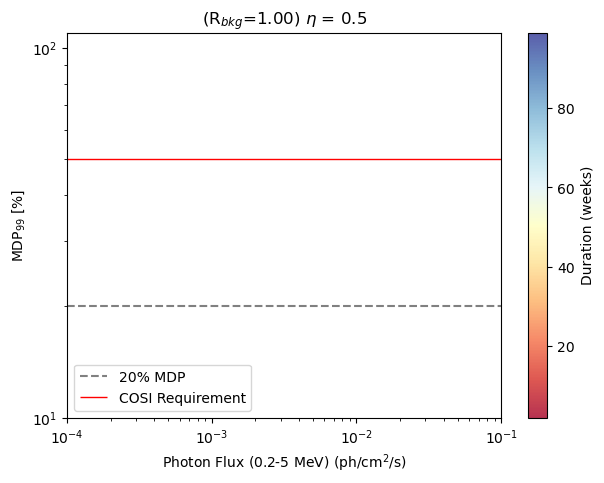

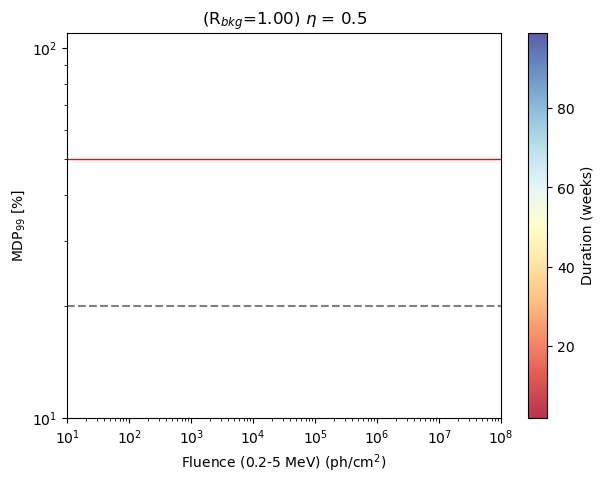

In [ ]:
#COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_Eta1.00.csv')
#COSI_bkg_rate = 0.1

#plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.ylim(10,110)
plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
plt.legend(loc=3)
#plt.savefig('Diagrams/Aug2025Plots/COSI_Flux_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f.png'%percent, dpi=200)


fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
cbar = plt.colorbar(sc)
cbar.set_label('Duration (weeks)')
plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
plt.ylim(10,110)
plt.xlim(10,1e+8)
plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.savefig('Diagrams/Aug2025Plots/COSI_Fluence_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f.png'%percent, dpi=200)

In [ ]:

f = '/home/lkoo/projects/LCRanalyses/Aug2025_COSI_0.5_Eta0.10.csv'
df2 = pd.read_csv(f, sep=',', index_col=False, header=0)
fsrq = df2[df2['Class'] == 'FSRQ']
# consider only MDP<=100
fsrq = fsrq[fsrq['MDP99'] <= 100]
dur = fsrq['Duration (weeks)']
dmin, dmax = dur.min(), dur.max()
fmin, fmax = fsrq['Photon Flux (ph/cm2/s)'].min(), fsrq['Photon Flux (ph/cm2/s)'].max()

# scale the duration values into a reasonable marker size range
sizes = 80 + 800 * (dur - dur.min()) / (dur.max() - dur.min())


# data
x = fsrq['Duration (weeks)'].to_numpy()
y = fsrq['Photon Flux (ph/cm2/s)'].to_numpy()
z = fsrq['MDP99'].to_numpy()



# log-spaced grid that matches your log axes
nx, ny = 300, 300
# dmin, dmax = x.min(), x.max()
# fmin, fmax = y.min(), y.max()
gx = np.logspace(np.log10(dmin), np.log10(120), nx)
gy = np.logspace(np.log10(fmin), np.log10(fmax), ny)
GX, GY = np.meshgrid(gx, gy, indexing='xy')  # GX.shape == GY.shape == (ny, nx)

# ---- interpolation (example: smoothed spline in log–log space) ----
xu, yu = np.log10(x), np.log10(y)
s = 1.0 * len(z) * np.var(z)                 # tune smoothing as needed
spline = SmoothBivariateSpline(xu, yu, z, s=s, kx=1, ky=1)

# Evaluate on grid; keep shape (ny, nx)
Z = spline.ev(np.log10(GX).ravel(), np.log10(GY).ravel()).reshape(GX.shape)

# ---- plot without transposes ----
fig, ax = plt.subplots(figsize=(8,6))
pcm = ax.pcolormesh(GX, GY, Z, shading='auto', cmap='RdBu_r', vmin=0, vmax=100, alpha=0.7)
plt.scatter(
    fsrq['Duration (weeks)'],
    fsrq['Photon Flux (ph/cm2/s)'],
    c=fsrq['MDP99'],
    cmap='RdBu_r',
    marker='o',
    s=sizes,            # size varies with duration
    edgecolor='k',
)


ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(3, 100); ax.set_ylim(gy.min(), gy.max())
ax.set_xlabel('Flare Duration (weeks)', size=15)
ax.set_ylabel('0.2–5 MeV Photon Flux (ph/cm²/s)', size=15)
ax.set_title(r'$\eta=0.5$, $R_{bkg}=0.1~ph/s$, Softer spectrum', size=15)
# make label of colorbar
cbar = plt.colorbar(label=r'$MDP_{99}$')
cbar.ax.tick_params(labelsize=15)
cbar.ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.tight_layout()
# plt.savefig(title_fig, dpi=200)



/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lkoo/miniconda3/envs/FlareResearch/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: The length of x, y and z should be at least (kx+1) * (ky+1)

### Automated Loop

In [ ]:
def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


UseFermiBand = False
#table = 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv'
background_ranges = [0.05, 0.1, 1]
#background_ranged = [1]
percent_ranges = [0.3, 0.5]
tables = ['COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv','COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis.csv']
#tables = ['COSICSV/COSI_factors_all_updated_only_logpar_flare_updated.csv']
for table in tables:
    if table == 'COSICSV/COSI_factors_all_updated_only_logpar_flare_updated_60deg_offaxis.csv':
        file_suffix = ''
    if table == 'COSICSV/COSI_factors_all_updated_only_logpar_flare_softer_+0.5_updated_60deg_offaxis.csv':
        file_suffix = '_Softer+0.5'
    for bkg in background_ranges:
        COSI_bkg_rate = bkg
        for per in percent_ranges:
            percent = per
            quiescent_background_calc_array = [0,0,0,0,0]
            COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
            flare_array = []
            COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
            #quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
            fsrq_names = select_fsrq()['Source_Name']
            bll_names = select_bll()['Source_Name']
            bcu_names = select_bcu()['Source_Name']
            for i,s in COSI_LAT_Sources.iterrows():
            #    print(i)
            #    print(s)
                Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]
                sourcename = COSI_LAT_Sources['Name'][i]
                #
                #if sourcename == '4FGL J1036.3-5833e':
                #    continue
                #if sourcename == '4FGL J1855.9+0121e':
                #    continue
                #if sourcename == '4FGL J1923.2+1408e':
                #    continue

                factor = COSI_LAT_Sources['ph/s_ratio'][i]
                if UseFermiBand == True:
                    Aeff = 1
                    factor = 1
                sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
                titlestring=sourcename
                print(sourcename)
                sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
                average_flux = np.nanmean(sourcearray['photon_flux2'])
                sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

                time = sourcearray['tmin']/SecsInDay + MJDREFI
                photon_flux = sourcearray['photon_flux2']
                errors = sourcearray['photon_flux_error2']

                sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
            #    if len(sourcelightcurve.time) == 0:
            #        continue
                maxflux = np.max(photon_flux)
                minflux = np.min(photon_flux)
                delta_flux = maxflux - minflux
                delta_flux_percent = delta_flux * percent
                thresholdflux = minflux + delta_flux_percent
                #thresholdflux = np.nanmean(photon_flux)
            #    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


                sourcelightcurve.get_bblocks(gamma_value=0.05)
                sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

                if not sourcelightcurve.hops:
                    continue

                quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

                if quiescent_background == np.nan:
                    continue
            #    print('printing quiescent background')
            #    print(quiescent_background)
                #sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
                sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

            #    if print(hops_bl[i]) == '(array([], dtype=int64),)':
            #        continue
            #    else:
                hops_bl = sourcelightcurve.hops
                try:
                    flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
                except:
                    continue
                #print(' ')
                #print(flarestack)
                #print('aaaaaaa')

                flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
                flareflux = flarestack[:,1].astype(float)*factor
                #print(flareintegrals)
                #print('bbbbbbbbbbbbb')
                flarenames = flarestack[:,0]
                #print(flarenames)
                flareduration = flarestack[:,3]
                background_counts = flarestack[:,4].astype(float) * 0.25
                starttime_s = flarestack[:,5]
                starttime_mjd = flarestack[:,6]
                fraction_time = flarestack[:,7]
                blazartype = flarestack[:,8]
                asymmetry = flarestack[:,9]
                quiescent_background_calc_array = np.vstack((quiescent_background_calc_array,np.array([flarenames,flareintegrals,[quiescent_background]*len(flarenames),fraction_time,blazartype]).T))
                COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype,asymmetry]).T
                COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))



            COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
            COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class','Asymmetry']


            COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!=0].reset_index(drop=True)
            COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
            COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
            COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
            COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
            COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),
                                                            COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
            COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
            COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
            COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)
            COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration (s)']<=2e8].reset_index(drop=True)


            neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)','Asymmetry']
            COSI_BAND_BAT_weekly_df[neworder].to_csv('November2025_COSI_%.1f'%percent+'_Eta%.2f'%COSI_bkg_rate+file_suffix+'.csv')

            
            # df2 = COSI_BAND_BAT_weekly_df
            # fsrq = df2[df2['Class'] == 'FSRQ']
            # # consider only MDP<=100
            # fsrq = fsrq[fsrq['MDP99'] <= 100]
            # dur = fsrq['Duration (weeks)']
            # dmin, dmax = dur.min(), dur.max()
            # fmin, fmax = fsrq['Photon Flux (ph/cm2/s)'].min(), fsrq['Photon Flux (ph/cm2/s)'].max()

            # # scale the duration values into a reasonable marker size range
            # sizes = 80 + 800 * (dur - dur.min()) / (dur.max() - dur.min())


            # # data
            # x = fsrq['Duration (weeks)'].to_numpy()
            # y = fsrq['Photon Flux (ph/cm2/s)'].to_numpy()
            # z = fsrq['MDP99'].to_numpy()

            # # log-spaced grid that matches your log axes
            # nx, ny = 300, 300
            # # dmin, dmax = x.min(), x.max()
            # # fmin, fmax = y.min(), y.max()
            # gx = np.logspace(np.log10(dmin), np.log10(120), nx)
            # gy = np.logspace(np.log10(fmin), np.log10(fmax), ny)
            # GX, GY = np.meshgrid(gx, gy, indexing='xy')  # GX.shape == GY.shape == (ny, nx)

            # # ---- interpolation (example: smoothed spline in log–log space) ----
            # xu, yu = np.log10(x), np.log10(y)
            # s = 1.0 * len(z) * np.var(z)                 # tune smoothing as needed
            # spline = SmoothBivariateSpline(xu, yu, z, s=s, kx=3, ky=3)

            # # Evaluate on grid; keep shape (ny, nx)
            # Z = spline.ev(np.log10(GX).ravel(), np.log10(GY).ravel()).reshape(GX.shape)

            # # ---- plot without transposes ----
            # fig, ax = plt.subplots(figsize=(8,6))
            # pcm = ax.pcolormesh(GX, GY, Z, shading='auto', cmap='RdBu_r', vmin=0, vmax=100, alpha=0.7)
            # plt.scatter(
            #     fsrq['Duration (weeks)'],
            #     fsrq['Photon Flux (ph/cm2/s)'],
            #     c=fsrq['MDP99'],
            #     cmap='RdBu_r',
            #     marker='o',
            #     s=sizes,            # size varies with duration
            #     edgecolor='k',
            # )


            # ax.set_xscale('log'); ax.set_yscale('log')
            # ax.set_xlim(3, 100); ax.set_ylim(gy.min(), gy.max())
            # ax.set_xlabel('Flare Duration (weeks)', size=15)
            # ax.set_ylabel('0.2–5 MeV Photon Flux (ph/cm²/s)', size=15)
            # ax.set_title(r'$\eta=0.5$, $R_{bkg}=0.1~ph/s$, Softer spectrum', size=15)
            # # make label of colorbar
            # cbar = plt.colorbar(label=r'$MDP_{99}$')
            # cbar.ax.tick_params(labelsize=15)
            # cbar.ax.yaxis.label.set_size(15)
            # ax.tick_params(axis='x', labelsize=15)
            # ax.tick_params(axis='y', labelsize=15)
            # plt.tight_layout()
            # plt.savefig(title_fig, dpi=200)



            # fig,ax = plt.subplots(figsize = (7,5))

            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            # cm = plt.get_cmap('RdYlBu')
            # z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
            # sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
            # cbar = plt.colorbar(sc)
            # cbar.set_label('Duration (weeks)')
            # plt.ylim(1,110)
            # plt.xlim(1e-4,1e-1)
            # plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
            # plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
            # plt.ylabel(r'MDP$_{99}$ [%]')
            # plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
            # plt.legend(loc=3)
            #plt.savefig('Diagrams/Aug2025Plots/COSI_Flux_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)


            # fig,ax = plt.subplots(figsize = (7,5))
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            # cm = plt.get_cmap('RdYlBu')
            # z = COSI_BAND_BAT_weekly_df['Duration (weeks)']
            # sc = plt.scatter(COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
            # cbar = plt.colorbar(sc)
            # cbar.set_label('Duration (weeks)')
            # plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
            # plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
            # plt.ylim(1,110)
            # plt.xlim(10,1e+8)
            # plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
            # plt.ylabel(r'MDP$_{99}$ [%]')
            #plt.savefig('Diagrams/Aug2025Plots/COSI_Fluence_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)
            #COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_Eta1.00.csv')


            #plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
            fig,ax = plt.subplots(figsize = (7,5))
            #plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
            #plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
            #plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            cm = plt.get_cmap('RdYlBu')
            z = COSI_BAND_BAT_weekly_df['MDP99']
            sc = plt.scatter(COSI_BAND_BAT_weekly_df['Duration (weeks)'],
                             COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'],
                             c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'],
                             cmap=cm,alpha = 0.8,edgecolors='k',vmax=100, vmin = 10)
            cbar = plt.colorbar(sc)
            cbar.set_label('MDP99')
            #plt.ylim(10,110)
            #plt.xlim(1e-4,1e-1)
            #plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
            #plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
            plt.xscale('log')
            plt.yscale('log')
            plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
            plt.xlabel(r'Duration (weeks)')
            plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
            plt.legend(loc=3)
            plt.savefig('Diagrams/Nov2025Plots/COSI_Duration_vs_PhotonFlux_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)


            # fig,ax = plt.subplots(figsize = (7,5))
            # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            # cm = plt.get_cmap('RdYlBu')
            # z = COSI_BAND_BAT_weekly_df['MDP99']
            # sc = plt.scatter(COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (weeks)'], cmap=cm,alpha = 0.8,edgecolors='k',vmax=np.max(z[z<100]))
            # cbar = plt.colorbar(sc)
            # cbar.set_label('MDP99')
            # plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
            # plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.title(r'(R$_{bkg}$=%.2f) '%COSI_bkg_rate + r'$\eta$ = %.1f'%percent)
            # plt.ylim(10,110)
            # plt.xlim(10,1e+8)
            # plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
            # plt.ylabel(r'MDP$_{99}$ [%]')
            # #plt.savefig('Diagrams/Aug2025Plots/COSI_Fluence_v_MDP99_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.png', dpi=200)
            
            dutycycle_arr=[0,0,0]
            print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
            for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
                sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
                if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
                    blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
                else:
                    blazartype = 'None'
                #print(blazartype)
                dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
                print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

                #print(flaringtime)
                sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
                #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
                #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
                #print('obstime is',obstime)
                dutycycle = [sourcename,dutycyclevalue,blazartype]
                dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

            filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
            pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'.csv',index=False)

            filteredutycycles = pd.concat([pd.read_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+'_Softer+0.5.csv',header=None),pd.read_csv('Diagrams/Nov2025Plots/DutyCycles_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+'.csv',header=None)],axis=0,ignore_index=True).to_numpy()

            y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),bins=20,density=True)
            x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
            x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
            y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),bins=20,density=True)
            x_bll = (xe_bll[:-1]+xe_bll[1:])/2
            x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)


            maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
            popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1],maxfev=5000)
            fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
            fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
            maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

            maxbll=maxwellian_function(x_bll,0.1,a=0.1)
            popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1],maxfev=5000)
            bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
            bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
            maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])


            fig,ax = plt.subplots(figsize = (7,5))

            plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
            plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
            plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
            plt.plot(x_bll_refine,maxbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')

            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            plt.legend()
            plt.ylabel('Density')
            plt.xlabel('Duty Cycle')
            plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')
            #plt.savefig('Diagrams/Aug2025Plots/DutyCycles_FSRQ&BLL_Rbkg%.2f'%COSI_bkg_rate+'_Eta%.1f'%percent+file_suffix+'_fit.png',dpi=200)


In [21]:
print(pd.DataFrame(flarestack[1]))

                     0
0    4FGL J1337.6-1257
1            6.086e-07
2  0.36808127999999996
3            3628800.0
4            3628800.0
5         4915425601.0
6    56891.50001157408
7  0.00681044267877412
8                 FSRQ
9                  0.0


Aeff test mean is 2.711656834451127
Aeff test std is 2.2235427306859585


Text(0, 0.5, 'Photon Count (ph)')

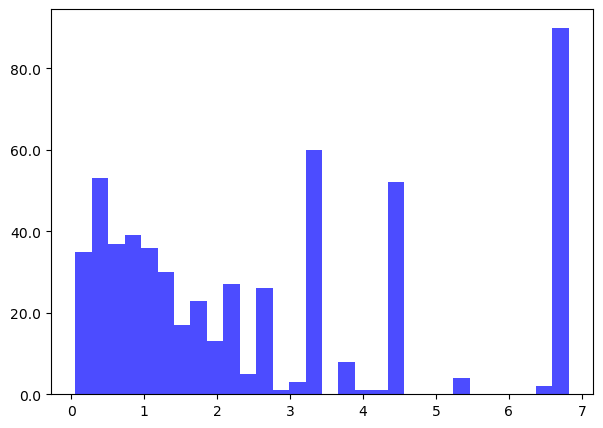

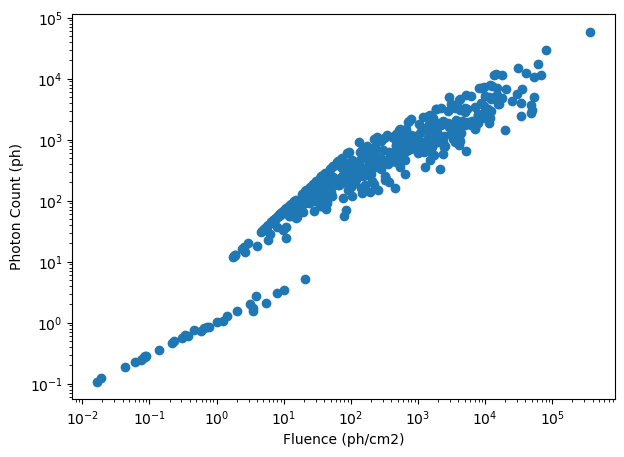

In [29]:
fluences = COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)']
photoncounts = COSI_BAND_BAT_weekly_df['Photon Count']
aefftest = photoncounts/fluences
print('Aeff test mean is',np.nanmean(aefftest))
print('Aeff test std is',np.nanstd(aefftest))
# plot fluences vs photon counts
fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cm = plt.get_cmap('RdYlBu')
plt.hist(x=aefftest,bins=30,color='blue',alpha=0.7)

plt.figure(figsize = (7,5))
plt.scatter(fluences,photoncounts)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Fluence (ph/cm2)')
plt.ylabel('Photon Count (ph)')

In [25]:
testquiescentweight = quiescent_df[quiescent_df['Name']=='4FGL J0001.5+2113']
testquiescentweight

NameError: name 'quiescent_df' is not defined

### Testing Sharp Method for Determining Quiescent Background

In [245]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward',thresholdflux=thresholdflux):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = thresholdflux)
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    fsrq_names = select_fsrq()['Source_Name']
    bll_names = select_bll()['Source_Name']
    bcu_names = select_bcu()['Source_Name']
    flarestack=[0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        print(len(hops_bl[i].iis))
        if len(hops_bl[i].iis) > 1:
            temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        else:
            temp = sourcelightcurve.flux[hops_bl[i].iis]
            print(hops_bl[i].iis)
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    
    return mdp99

In [246]:

table = 'COSI_factors_all_updated.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]
    #
    #if sourcename == '4FGL J1036.3-5833e':
    #    continue
    #if sourcename == '4FGL J1855.9+0121e':
    #    continue
    #if sourcename == '4FGL J1923.2+1408e':
    #    continue

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward',thresholdflux=thresholdflux)
    #sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)
    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
        flareflux = flarestack[:,1].astype(float)*factor
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,3]
        background_counts = flarestack[:,4]
        starttime_s = flarestack[:,5]
        starttime_mjd = flarestack[:,6]
        fraction_time = flarestack[:,7]
        blazartype = flarestack[:,8]

        COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class']

COSI_BAND_BAT_weekly_df


FileNotFoundError: [Errno 2] No such file or directory: 'COSI_factors_all_updated.csv'

### Duty Cycle Calculations

In [ ]:
dutycycle_arr=[0,0,0]
    COSI_BAND_BAT_weekly_df=pd.read_csv(csv_string)
    #COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.1Softer.csv')
    print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
    for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
        sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
        if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
            blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
        else:
            blazartype = 'None'
        #print(blazartype)
        dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
        print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

        #print(flaringtime)
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
        #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
        #print('obstime is',obstime)
        dutycycle = [sourcename,dutycyclevalue,blazartype]
        dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

    filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
    pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('Diagrams/Aug2025Plots/DutyCycles_Eta%.1f'%percent+file_suffix+'.csv',index=False)


    plt.figure()
    plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Duty Cycle Ratio')
    plt.title('Duty Cycle Ratio Distribution of FSRQs')
    plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Duty Cycle Ratio')
    plt.title('Duty Cycle Ratio Distribution Flare Populations')
    plt.figure()
    plt.savefig('Diagrams/Aug2025Plots/DutyCycles_FSRQ&BLL_Eta%.1f'%percent+file_suffix+'png',dpi=200)

    plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
    plt.legend()
    plt.ylabel('Density')
    plt.xlabel('Duty Cycle Ratio')
    plt.title('Duty Cycle Ratio Distribution BCUs')
    plt.figure()
    plt.savefig('Diagrams/Aug2025Plots/DutyCycles_BCU_Eta%.1f'%percent+file_suffix+'png',dpi=200)
    #plt.savefig('DutyCycles/DutyCycle_BCU_0.5.png')
    #plt.yscale('log')
    #plt.xscale('log')

In [84]:
dutycycle_arr=[0,0,0]
#COSI_BAND_BAT_weekly_df=pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts).csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.1Softer.csv')
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'None'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

305
0    0.0
Name: Fraction of Observation Time, dtype: float64
1     0.005137
2     0.002283
3     0.018265
4     0.006279
5     0.014840
6     0.002854
7     0.014269
8     0.007991
9     0.057078
10    0.017123
11    0.004566
Name: Fraction of Observation Time, dtype: float64
12    0.292824
13    0.116319
14    0.273148
Name: Fraction of Observation Time, dtype: float64
15    0.192841
Name: Fraction of Observation Time, dtype: float64
16    0.204105
17    0.014823
18    0.064424
Name: Fraction of Observation Time, dtype: float64
19    0.280854
20    0.292964
21    0.162053
22    0.107843
Name: Fraction of Observation Time, dtype: float64
23    0.007955
24    0.121591
25    0.004545
26    0.090341
27    0.101136
Name: Fraction of Observation Time, dtype: float64
28    0.054819
Name: Fraction of Observation Time, dtype: float64
29    0.16088
Name: Fraction of Observation Time, dtype: float64
30    0.169931
31    0.206221
Name: Fraction of Observation Time, dtype: float64
32    0.13097

Text(0.5, 1.0, 'Duty Cycle Ratio Distribution BCUs')

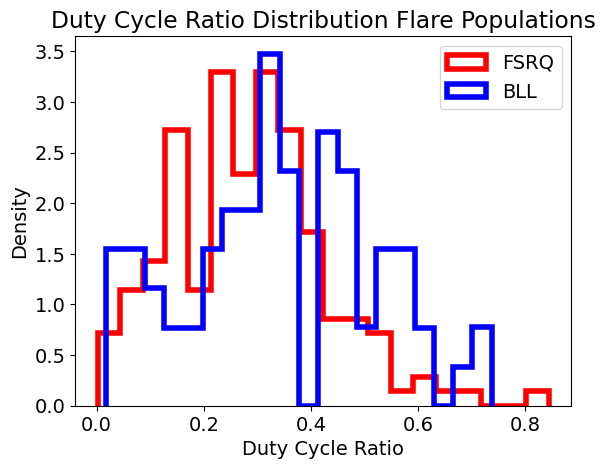

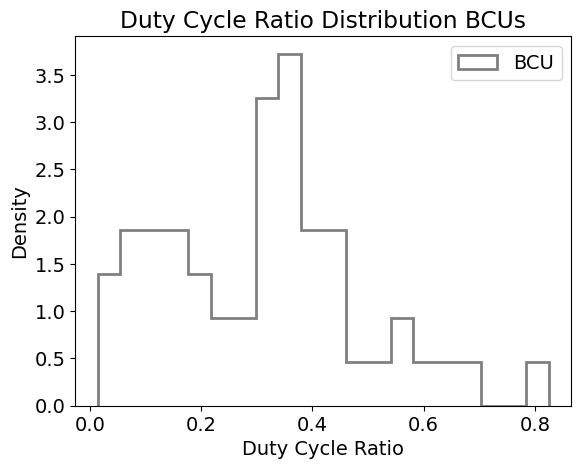

In [85]:
filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
#pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True).to_csv('DutyCyclesFSRQBLL.csv',index=False)
plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution of FSRQs')
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution Flare Populations')
plt.figure()
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5.png')

plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Ratio Distribution BCUs')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5.png')
#plt.yscale('log')
#plt.xscale('log')

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1080/1058908548.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_1080/1058908548.py:47: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sig

0.18840212994689928 0.24010510620562997


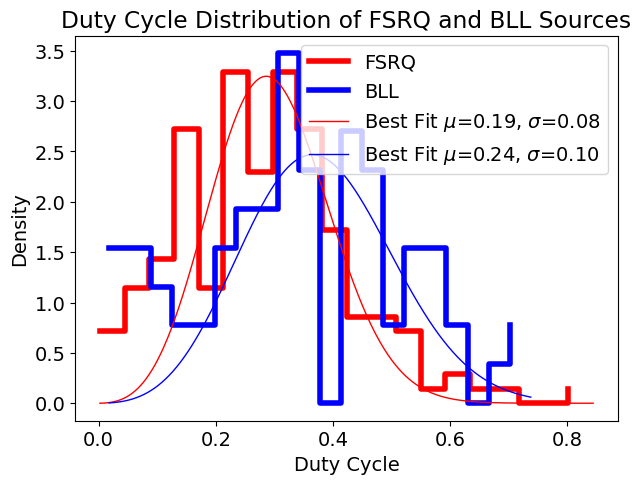

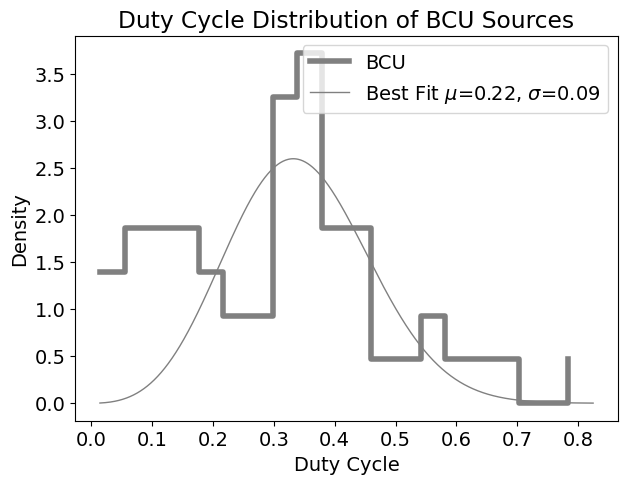

In [87]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit


def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1],maxfev=5000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

maxbll=maxwellian_function(x_bll,0.1,a=0.1)
popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1],maxfev=5000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])

maxbcu=maxwellian_function(x_bcu,0.1,a=0.1)
popt_bcu, pcov_bcu = curve_fit(maxwellian_function, x_bcu, y_bcu,p0=[0.1,0.1],maxfev=5000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbcu = maxwellian_function(x_bcu_refine,popt_bcu[0],popt_bcu[1])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,maxfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,maxbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,maxbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle')
plt.title('Duty Cycle Distribution of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')
print(fsrq_mean,bll_mean)


In [79]:
print(x_fsrq[y_fsrq.argmax()])
print(x_bll[y_bll.argmax()])
print(x_bcu[y_bcu.argmax()])

0.24474666388657207
0.36630062961677634
0.29412228144320185


In [80]:
x_fsrq

array([0.02197352, 0.05910238, 0.09623123, 0.13336009, 0.17048895,
       0.20761781, 0.24474666, 0.28187552, 0.31900438, 0.35613324,
       0.39326209, 0.43039095, 0.46751981, 0.50464867, 0.54177752,
       0.57890638, 0.61603524, 0.6531641 , 0.69029295, 0.72742181])

In [168]:
stats.ks_2samp(data1=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),data2 = filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float))

KstestResult(statistic=np.float64(0.3354024829795755), pvalue=np.float64(7.587007727346903e-07), statistic_location=np.float64(0.30501710376282765), statistic_sign=np.int8(1))

### Plotting Distribution of New Flares

In [16]:
#FlareTable = pd.read_csv('COSI_BAND_ALL_weekly_RbkgUpdated0.10.csv', sep=",", na_filter=True)
FlareTable = COSI_BAND_BAT_weekly_df
fsrq_flares = FlareTable[FlareTable['Class']=='FSRQ']
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']<100]
fsrq_flares = fsrq_flares[fsrq_flares['Photon Flux (ph/cm2/s)']>10e-12]
bll_flares = FlareTable[FlareTable['Class']=='BLL']
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']<100]
bll_flares = bll_flares[bll_flares['Photon Flux (ph/cm2/s)']>10e-12]
bcu_flares = FlareTable[FlareTable['Class']=='BCU']
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']<100]
bcu_flares = bcu_flares[bcu_flares['Photon Flux (ph/cm2/s)']>10e-12]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']<100]
FlareTable = FlareTable[FlareTable['Photon Flux (ph/cm2/s)']>10e-12]

<function matplotlib.pyplot.show(close=None, block=None)>

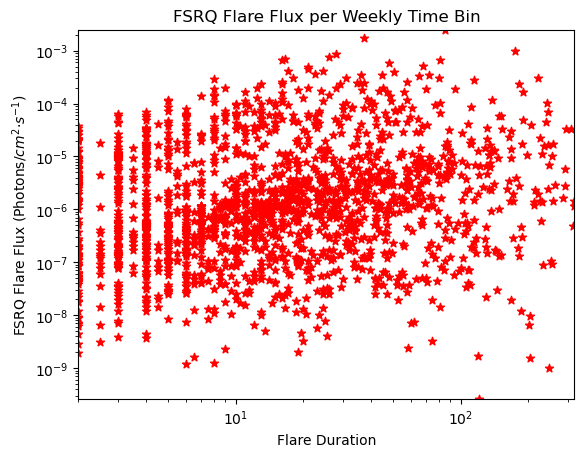

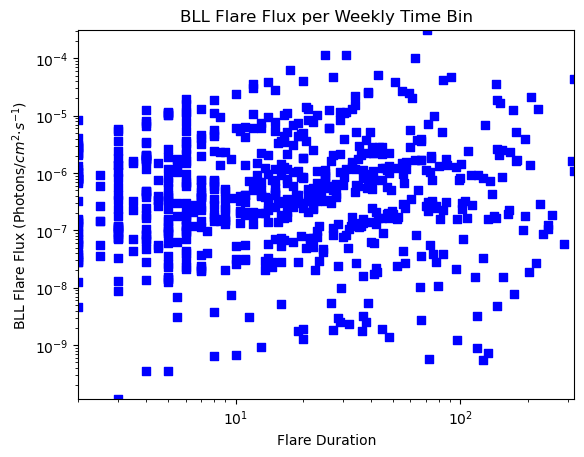

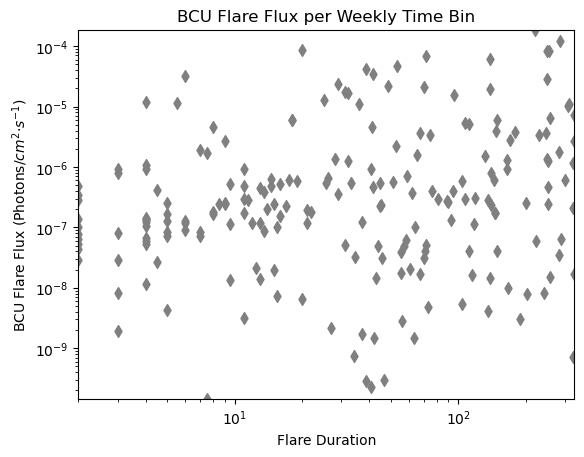

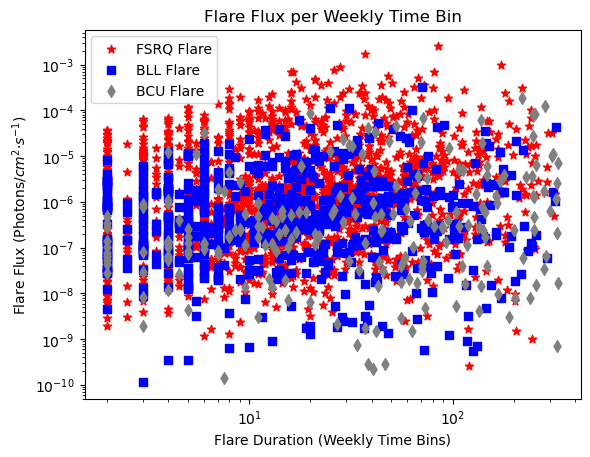

In [17]:
cl = ['r','blue','gray'] # List of colours for categories


# This section makes four Average Flux vs Duration plots: one for each category of blazars, and a final plot for all three together.
#print(pd.DataFrame(fsrq_flares[:,1]))
fsrq_ysize = fsrq_flares['Photon Flux (ph/cm2/s)'].size
fsrq_x = np.asarray(fsrq_flares['Duration (weeks)'],dtype='float64')
fsrq_xmin = min(fsrq_x)
fsrq_xmax = max(fsrq_x)
fsrq_y = np.asarray(fsrq_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
fsrq_ymin = min(fsrq_y)
fsrq_ymax = max(fsrq_y)
#fsrq_err= np.asarray(fsrq_plot[:,3],dtype='float64')
plt.ylim([fsrq_ymin,fsrq_ymax])
plt.xlim([fsrq_xmin,fsrq_xmax])
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0])
#plt.errorbar(fsrq_x,fsrq_y,,fmt = '*',color='#FF005D')
plt.ylabel('FSRQ Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('FSRQ Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bll_ysize = bll_flares['Photon Flux (ph/cm2/s)'].size
bll_x = np.asarray(bll_flares['Duration (weeks)'],dtype='float64')
bll_xmin = min(bll_x)
bll_xmax = max(bll_x)
bll_y = np.asarray(bll_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bll_ymin = min(bll_y)
bll_ymax = max(bll_y)
#bll_err= np.asarray(bll_plot[:,3],dtype='float64')
plt.ylim([bll_ymin,bll_ymax])
plt.xlim([bll_xmin,bll_xmax])
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1])
#plt.errorbar(bll_x,bll_y,,fmt = '*',color='#FF005D')
plt.ylabel('BLL Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BLL Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()

bcu_ysize = bcu_flares['Photon Flux (ph/cm2/s)'].size
bcu_x = np.asarray(bcu_flares['Duration (weeks)'],dtype='float64')
bcu_xmin = min(bcu_x)
bcu_xmax = max(bcu_x)
bcu_y = np.asarray(bcu_flares['Photon Flux (ph/cm2/s)'],dtype='float64')
bcu_ymin = min(bcu_y)
bcu_ymax = max(bcu_y)
#bcu_err= np.asarray(bcu_plot[:,3],dtype='float64')
plt.ylim([bcu_ymin,bcu_ymax])
plt.xlim([bcu_xmin,bcu_xmax])
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2])
#plt.errorbar(bcu_x,bcu_y,,fmt = '*',color='#FF005D')
plt.ylabel('BCU Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration')
plt.title('BCU Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
plt.figure()



#Combined Graphic
plt.scatter(fsrq_x,fsrq_y,marker = '*',color=cl[0],label='FSRQ Flare')
#plt.errorbar(fsrq_x,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')
plt.scatter(bll_x,bll_y,marker = 's',color=cl[1],label='BLL Flare')
#plt.errorbar(bll_x,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
plt.scatter(bcu_x,bcu_y,marker = 'd',color=cl[2],label='BCU Flare')
#plt.errorbar(bcu_x,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')
plt.legend()
plt.ylabel('Flare Flux (Photons/$cm^2\u22c5s^{-1}$)')
plt.xlabel('Flare Duration (Weekly Time Bins)')
plt.title('Flare Flux per Weekly Time Bin')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(10,40)
#plt.ylim(0.0000001,0.000002)
plt.show
#Flux is 1/cm^2*s


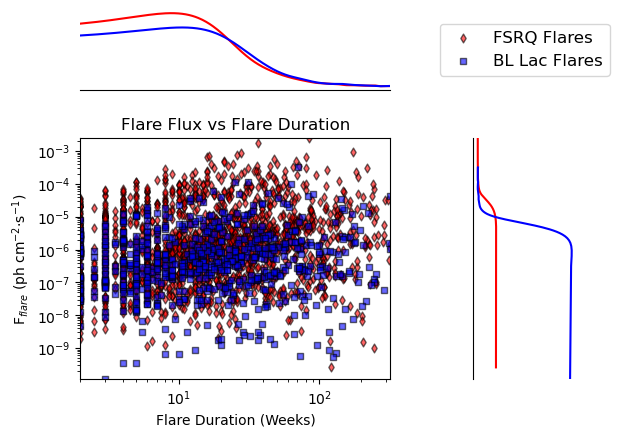

In [18]:
from matplotlib import gridspec

# Graph modified for Weekly Cadence
label = ['FSRQ Flares','BL Lac Flares','BCU Flares'] # List of labels for categories
cl = ['r','blue','gray'] # List of colours for categories
categories = len(label)


# Set up 4 subplots as axis objects using GridSpec:
gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[1,3])
# Add space between scatter plot and KDE plots to accommodate axis labels:
gs.update(hspace=0.3, wspace=0.4)

# Set background canvas colour to White instead of grey default
fig = plt.figure()
fig.patch.set_facecolor('white')

ax = plt.subplot(gs[1,0]) # Instantiate scatter plot area and axis range
#ax.set_ylim(10**-8,10**-5)
#ax.set_xlim(10,100)
ax.set_xlim(min(fsrq_xmin,bll_xmin), max(fsrq_xmax,bll_xmax))
ax.set_ylim(min(fsrq_ymin,bll_ymin), max(fsrq_ymax,bll_ymax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Flare Duration (Weeks)')
ax.set_ylabel('F$_{flare}$ (ph cm$^{-2}$\u22c5s$^{-1}$)')
ax.set_title('Flare Flux vs Flare Duration')

axl = plt.subplot(gs[1,1], sharey=ax) # Instantiate left KDE plot area
axl.get_xaxis().set_visible(False) # Hide tick marks and spines
axl.get_yaxis().set_visible(False)
axl.spines["right"].set_visible(False)
axl.spines["top"].set_visible(False)
axl.spines["bottom"].set_visible(False)

axb = plt.subplot(gs[0,0], sharex=ax) # Instantiate bottom KDE plot area
axb.get_xaxis().set_visible(False) # Hide tick marks and spines
axb.get_yaxis().set_visible(False)
axb.spines["right"].set_visible(False)
axb.spines["top"].set_visible(False)
axb.spines["left"].set_visible(False)

axc = plt.subplot(gs[0,1]) # Instantiate legend plot area
axc.axis('off') # Hide tick marks and spines

# Plot data for each categorical variable as scatter and marginal KDE plots:
#FSRQ PLOT
ax.scatter(fsrq_x, fsrq_y, marker = 'd', color = cl[0], label=label[0], s=20, edgecolors= 'black',alpha = 0.6)
#ax.errorbar(fsrq_x*3,fsrq_y,yerr=fsrq_err,fmt = '*',color='#FF005D')    
kde = stats.gaussian_kde(fsrq_x)
fsrq_xx = np.linspace(fsrq_xmin,fsrq_xmax,1000)
axb.plot(fsrq_xx,kde(fsrq_xx), color=cl[0],)
kde = stats.gaussian_kde(fsrq_y)
fsrq_yy = np.linspace(fsrq_ymin,fsrq_ymax,1000)
axl.plot(kde(fsrq_yy), fsrq_yy, color=cl[0])

#BLL PLOT
ax.scatter(bll_x,bll_y, marker = 's', color=cl[1], label=label[1], s=20, edgecolors = 'black',alpha = 0.6)
plt.xlim(np.log(10),np.max([np.max(fsrq_x.astype(float)),np.max(bll_x.astype(float))]))
#ax.errorbar(bll_x*3,bll_y,yerr=bll_err,fmt = 's',color='#1E88E5')
kde = stats.gaussian_kde(bll_x)
bll_xx = np.linspace(bll_xmin,bll_xmax,1000)
axb.plot(bll_xx, kde(bll_xx), color=cl[1])
kde = stats.gaussian_kde(bll_y)
bll_yy = np.linspace(bll_ymin,bll_ymax,1000)
axl.plot(kde(bll_yy), bll_yy, color=cl[1])

#BCU PLOT
#ax.scatter(bcu_x,bcu_y, marker = 'd', color=cl[2], label=label[2], s=20, edgecolor= cl[2])
#ax.errorbar(bcu_x*3,bcu_y,yerr=bcu_err,fmt = 'd',color='#FFC107')

#kde = stats.gaussian_kde(bcu_x)
#bcu_xx = np.linspace(bcu_xmin,bcu_xmax,1000)
#axb.plot(bcu_xx, kde(bcu_xx), color=cl[2])
#kde = stats.gaussian_kde(bcu_y)
#bcu_yy = np.linspace(bcu_ymin,bcu_ymax,1000)
#axl.plot(kde(bcu_yy), bcu_yy, color=cl[2])

# Copy legend object from scatter plot to lower left subplot and display:
# NB 'scatterpoints = 1' customises legend box to show only 1 handle (icon) per label 
handles, labels = ax.get_legend_handles_labels()
axc.legend(handles, labels, scatterpoints = 1, loc = 'center', fontsize = 12)
plt.show()

In [19]:
np.min(fsrq_x)

np.float64(2.0)

In [20]:

fsrq_filtered = fsrq_flares
fsrq_flareduration = fsrq_filtered['Duration (weeks)']
fsrq_flareflux = fsrq_filtered['Photon Flux (ph/cm2/s)']
#fsrq_flareflux_error = fsrq_filtered[]
fsrq_flareduration=np.asarray(fsrq_flareduration,dtype='float64')
fsrq_flareflux=np.asarray(fsrq_flareflux,dtype='float64')
#fsrq_flareflux_error=np.asarray(fsrq_flareflux_error,dtype='float64')
fsrq_fluence = np.multiply(fsrq_flareflux,fsrq_flareduration)*(7*24*60*60)
#fsrq_fluence_error = (np.multiply(fsrq_flareflux_error,fsrq_flareduration)**2)**0.5
#pd.DataFrame(fsrq_flareduration)
#pd.DataFrame(fsrq_flareflux)
pd.DataFrame(fsrq_fluence)
fsrq_fluencecount = np.zeros(len(fsrq_fluence))
#fsrq_fluencecount_error = np.zeros(len(fsrq_fluence))
fsrq_fluencethresholds=sorted(fsrq_fluence)
for i in range(0,len(fsrq_fluence)):
    fsrq_fluencecount[i]=len(fsrq_fluence[fsrq_fluence>fsrq_fluencethresholds[i]])
    #fsrq_fluencecount_error[i]=fsrq_fluencecount[i]**0.5
pd.DataFrame(fsrq_fluencethresholds)

bll_filtered = bll_flares
bll_flareduration = bll_filtered['Duration (weeks)']
bll_flareflux = bll_filtered['Photon Flux (ph/cm2/s)']
#bll_flareflux_error = bll_filtered[:,3]
bll_flareduration=np.asarray(bll_flareduration,dtype='float64')
bll_flareflux=np.asarray(bll_flareflux,dtype='float64')
#bll_flareflux_error=np.asarray(bll_flareflux_error,dtype='float64')
bll_fluence = np.multiply(bll_flareflux,bll_flareduration)*(7*24*60*60)
#pd.DataFrame(bll_flareduration)
#pd.DataFrame(bll_flareflux)
pd.DataFrame(bll_fluence)
bll_fluencecount = np.zeros(len(bll_fluence))
#bll_fluencecount_error = np.zeros(len(bll_fluence))

bll_fluencethresholds=sorted(bll_fluence)
for i in range(0,len(bll_fluence)):
    bll_fluencecount[i]=len(bll_fluence[bll_fluence>bll_fluencethresholds[i]])
    #bll_fluencecount_error[i]=bll_fluencecount[i]**0.5

pd.DataFrame(bll_fluencethresholds)


bcu_filtered = bcu_flares
bcu_flareduration = bcu_filtered['Duration (weeks)']
bcu_flareflux = bcu_filtered['Photon Flux (ph/cm2/s)']
#bcu_flareflux_error = bcu_filtered[:,3]
bcu_flareduration=np.asarray(bcu_flareduration,dtype='float64')*(7*24*60*60)
bcu_flareflux=np.asarray(bcu_flareflux,dtype='float64')
#bcu_flareflux_error=np.asarray(bcu_flareflux_error,dtype='float64')
bcu_fluence = np.multiply(bcu_flareflux,bcu_flareduration)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(bcu_fluence)
bcu_fluencecount = np.zeros(len(bcu_fluence))
#bcu_fluencecount_error = np.zeros(len(bcu_fluence))

bcu_fluencethresholds=sorted(bcu_fluence)
for i in range(0,len(bcu_fluence)):
    bcu_fluencecount[i]=len(bcu_fluence[bcu_fluence>bcu_fluencethresholds[i]])
    #bcu_fluencecount_error[i]=bcu_fluencecount[i]**0.5

pd.DataFrame(bcu_fluencethresholds)

total_filtered = FlareTable
total_flareduration = total_filtered['Duration (weeks)']
total_flareflux = total_filtered['Photon Flux (ph/cm2/s)']
#total_flareflux_error = total_filtered[:,3]
total_flareduration=np.asarray(total_flareduration,dtype='float64')
total_flareflux=np.asarray(total_flareflux,dtype='float64')
total_fluence = np.multiply(total_flareflux,total_flareduration)*(7*24*60*60)
#pd.DataFrame(bcu_flareduration)
#pd.DataFrame(bcu_flareflux)
pd.DataFrame(total_fluence)
total_fluencecount = np.zeros(len(total_fluence))
#total_fluencecount_error = np.zeros(len(total_fluence))
total_fluencethresholds=sorted(total_fluence)
for i in range(0,len(total_fluence)):
    total_fluencecount[i]=len(total_fluence[total_fluence>total_fluencethresholds[i]])
    #total_fluencecount_error[i]=total_fluencecount[i]**0.5
print(max(total_fluencecount))

#np.save('shared_plot_arrays/FERMI_fsrq_fluencecount_0.1.npy',np.array(fsrq_fluencecount))
#np.save('shared_plot_arrays/FERMI_bll_fluencecount_0.1.npy',np.array(bll_fluencecount_error))
#np.save('shared_plot_arrays/FERMI_bcu_fluencecount_0.1.npy',np.array(bcu_fluencecount_error))


2959.0


In [21]:
fsrqDataframe = pd.DataFrame([fsrq_fluencecount,fsrq_fluencethresholds]).transpose()
fsrqDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bllDataframe = pd.DataFrame([bll_fluencecount,bll_fluencethresholds]).transpose()
bllDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

bcuDataframe = pd.DataFrame([bcu_fluencecount,bcu_fluencethresholds]).transpose()
bcuDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

totalDataframe = pd.DataFrame([total_fluencecount,total_fluencethresholds]).transpose()
totalDataframe.rename(columns={0:'# of Flares',1:'Detection Threshold (ph/cm^2)'},inplace=True)

fsrqDataframe.to_csv('shared_plot_arrays/FERMI_fsrq_fluence_curve_0.3.csv',index=False)
bllDataframe.to_csv('shared_plot_arrays/FERMI_bll_fluence_curve_0.3.csv',index=False)
bcuDataframe.to_csv('shared_plot_arrays/FERMI_bcu_fluence_curve_0.3.csv',index=False)
totalDataframe.to_csv('shared_plot_arrays/FERMI_total_fluence_curve_0.3.csv',index = False)

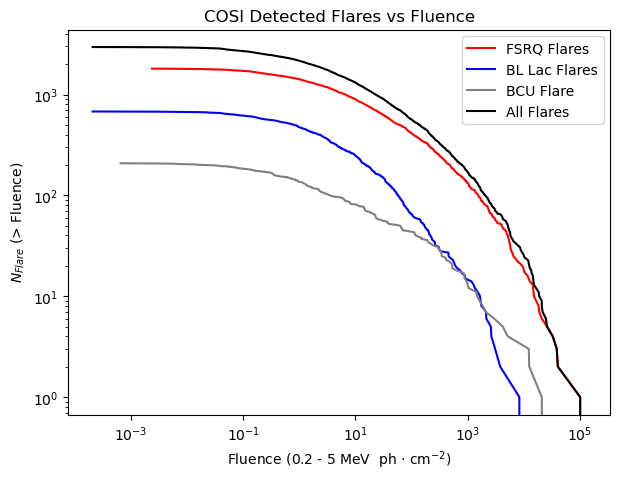

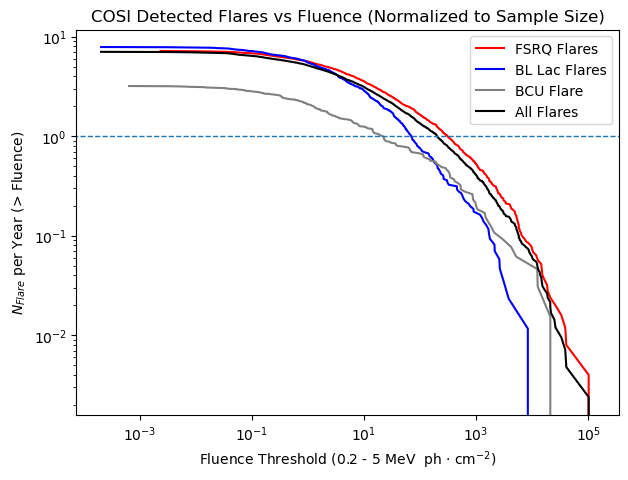

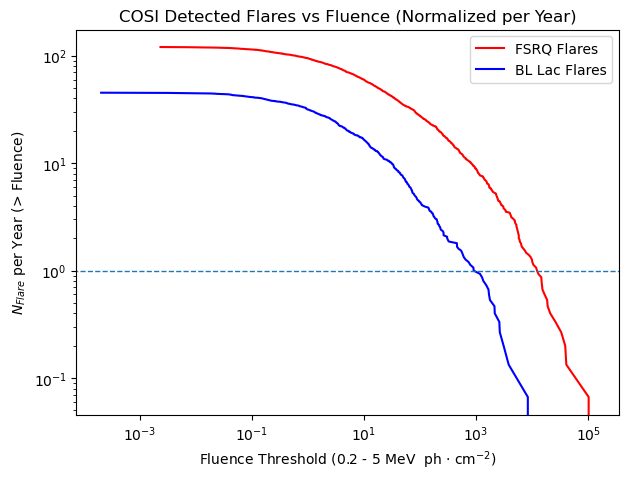

In [22]:
label = ['FSRQ Flares','BL Lac Flares','BCU Flare','All Flares'] # List of labels for categories
cl = ['r','blue','gray','000000'] # List of colours for categories

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount, yerr=fsrq_fluencecount_error, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/cm^2)')



plt.plot(bll_fluencethresholds,bll_fluencecount, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount, yerr=bll_fluencecount_error, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(bcu_fluencethresholds,bcu_fluencecount, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount, yerr=bcu_fluencecount_error, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')


plt.plot(total_fluencethresholds,total_fluencecount, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount, yerr=total_fluencecount_error, color=cl[3])
plt.yscale('log')
#plt.ylim(9,10**4)
#plt.xlim(10**-4,10**8)
plt.xscale('log')
plt.ylabel('$N_{Flare}$ (> Fluence)')
plt.xlabel('Fluence (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence')

plt.legend()

fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/len(fsrq_flares['Name'].drop_duplicates(keep='first')), color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/len(bll_flares['Name'].drop_duplicates(keep='first')), color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(bcu_fluencethresholds,bcu_fluencecount/len(bcu_flares['Name'].drop_duplicates(keep='first')), color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

plt.plot(total_fluencethresholds,total_fluencecount/len(FlareTable['Name'].drop_duplicates(keep='first')), color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized to Sample Size)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
plt.legend()


fig,ax = plt.subplots(figsize = (7,5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.plot(fsrq_fluencethresholds,fsrq_fluencecount/15, color=cl[0], label=label[0])
#plt.errorbar(fsrq_fluencethresholds,fsrq_fluencecount/15, yerr=fsrq_fluencecount_error/15, color=cl[0])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photns/cm^2)')

plt.plot(bll_fluencethresholds,bll_fluencecount/15, color=cl[1], label=label[1])
#plt.errorbar(bll_fluencethresholds,bll_fluencecount/15, yerr=bll_fluencecount_error/15, color=cl[1])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(bcu_fluencethresholds,bcu_fluencecount/15, color=cl[2], label=label[2])
#plt.errorbar(bcu_fluencethresholds,bcu_fluencecount/15, yerr=bcu_fluencecount_error/15, color=cl[2])
plt.yscale('log')
plt.xscale('log')
plt.ylabel('N (number of Fluence Counts)')
plt.xlabel('Fluence Threshold (photons/m^2)')

#plt.plot(total_fluencethresholds,total_fluencecount/15, color=cl[3], label=label[3])
#plt.errorbar(total_fluencethresholds,total_fluencecount/15, yerr=total_fluencecount_error/15, color=cl[3])
plt.yscale('log')
plt.xscale('log')
#plt.ylim(10/15,10**3)
#plt.xlim(10**-4,10**8)
plt.ylabel('$N_{Flare}$ per Year (> Fluence)')
plt.xlabel('Fluence Threshold (0.2 - 5 MeV  ph \u22c5 cm$^{-2}$)')
plt.title('COSI Detected Flares vs Fluence (Normalized per Year)')
plt.hlines(1,10**-10,10**10,linewidth=1,linestyles='--')
#plt.ylim(1,np.max(fsrq_fluencecount))

plt.legend()


In [ ]:


sourcename = '4FGL J1229.0+0202'
#
#if sourcename == '4FGL J1036.3-5833e':
#    continue
#if sourcename == '4FGL J1855.9+0121e':
#    continue
#if sourcename == '4FGL J1923.2+1408e':
#    continue

sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename

sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.nanmean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2']
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
#thresholdflux = np.nanmean(photon_flux)
print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method='baseline', lc_edges ='add', baseline = thresholdflux)

if not sourcelightcurve.hops:
    print('no hops found in first run')

quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')

if quiescent_background == np.nan:
    print('background is nan')
print('printing quiescent background')
print(quiescent_background)
#sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)

#    if print(hops_bl[i]) == '(array([], dtype=int64),)':
#        continue
#    else:
hops_bl = sourcelightcurve.hops

hops_bl[1].asym

4.36e-06 3.54e-08 4.3246e-06 1.29738e-06 1.3327799999999998e-06
Quiescent Background: 2.672527439024391e-07, Error: 2.3783736555880743e-09
printing quiescent background
2.672527439024391e-07


-0.0625

In [453]:
lc_array[2][lc_array[1]=='FSRQ']

array([LightCurve (bins = 252, name = 4FGL J0001.5+2113, cadende = None, telescope = None, z = None),
       LightCurve (bins = 195, name = 4FGL J0019.6+7327, cadende = None, telescope = None, z = None),
       LightCurve (bins = 310, name = 4FGL J0030.3-4224, cadende = None, telescope = None, z = None),
       LightCurve (bins = 124, name = 4FGL J0051.5-4220, cadende = None, telescope = None, z = None),
       LightCurve (bins = 456, name = 4FGL J0102.8+5824, cadende = None, telescope = None, z = None),
       LightCurve (bins = 606, name = 4FGL J0108.6+0134, cadende = None, telescope = None, z = None),
       LightCurve (bins = 345, name = 4FGL J0112.8+3208, cadende = None, telescope = None, z = None),
       LightCurve (bins = 136, name = 4FGL J0116.0-1136, cadende = None, telescope = None, z = None),
       LightCurve (bins = 308, name = 4FGL J0118.9-2141, cadende = None, telescope = None, z = None),
       LightCurve (bins = 286, name = 4FGL J0133.1-5201, cadende = None, telescope

In [ ]:
fsrq_array = lc_array[2][lc_array[1]=='FSRQ']
bcu_array = lc_array[2][lc_array[1]=='BCU']
bll_array = lc_array[2][lc_array[1]=='BLL']

### Asymmetry

In [139]:
#COSI_BAND_BAT_weekly_df = pd.read_csv('Aug2025_COSI_0.5_(0.1 Counts)_Softer.csv')
#COSI_BAND_BAT_weekly_df = pd.read_csv('COSI+0.5Softer.csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

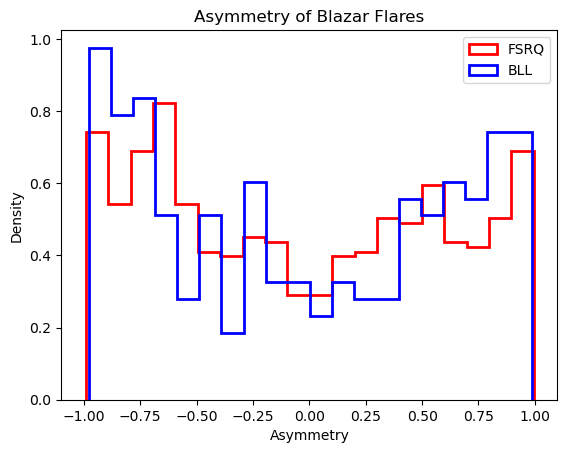

In [140]:
plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()


<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\m'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/2205562540.py:45: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

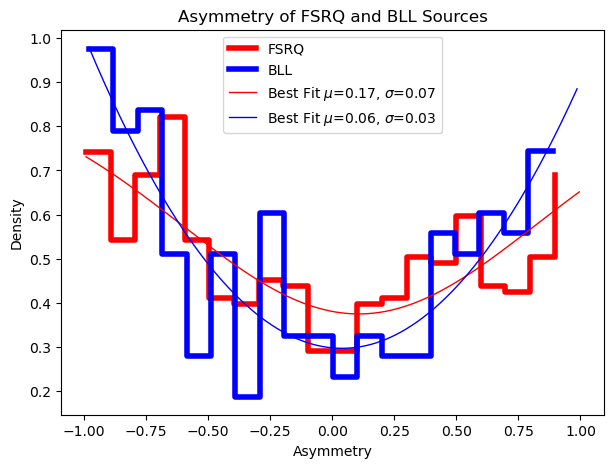

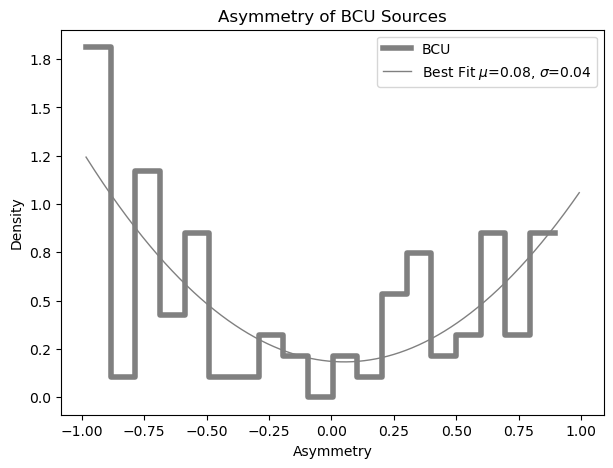

In [141]:
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')


<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\m'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
/tmp/ipykernel_928/1424120370.py:63: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\s

Text(0.5, 1.0, 'Asymmetry of BCU Sources')

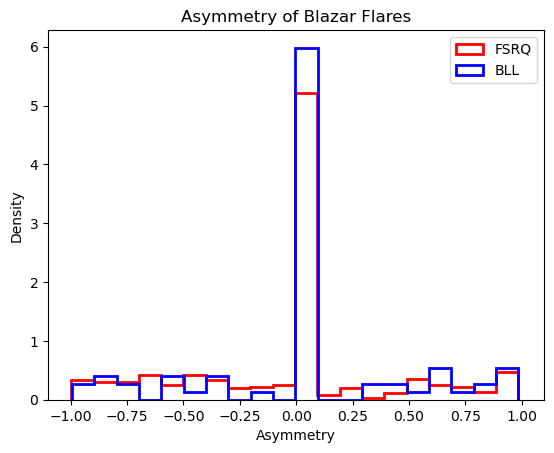

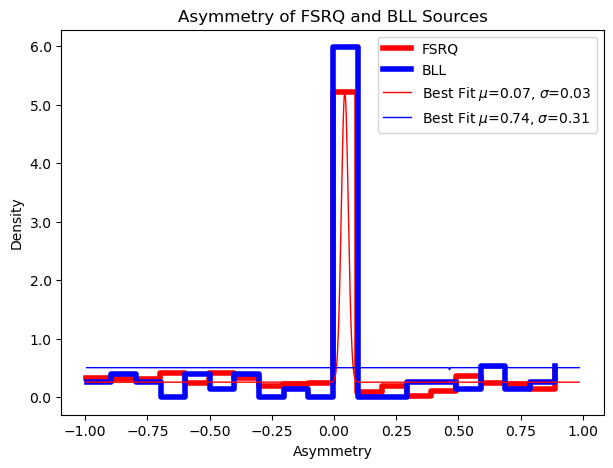

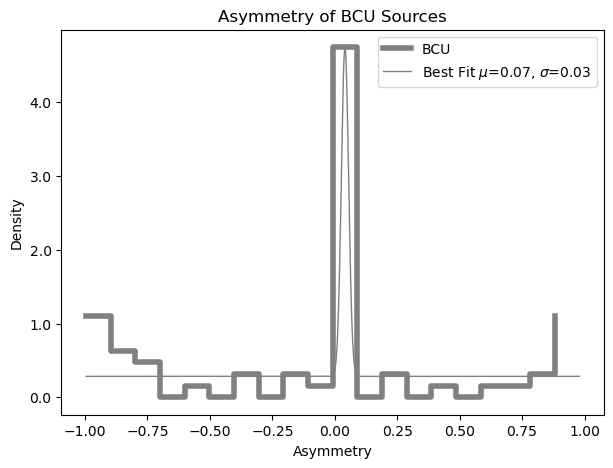

In [142]:
COSI_BAND_BAT_weekly_df2 = pd.read_csv('Aug2025_COSI_0.1_(0.1 Counts).csv')
asymmetrymatrix = COSI_BAND_BAT_weekly_df2[['Asymmetry','Class']]
asymmetrymatrix = asymmetrymatrix[asymmetrymatrix['Asymmetry'] != '0.0']

plt.figure()
plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=2)

plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=2)

#plt.hist(x=asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),label='BCU',bins=20,density=True,histtype='step',color='gray',linewidth=2)

#plt.hist(x=asymmetrymatrix['Asymmetry'].astype(float),label='ALL',bins=20,density=True,histtype='step',color='black',linewidth=2)
plt.xlim(-1.1,1.1)
plt.title('Asymmetry of Blazar Flares')
plt.xlabel('Asymmetry')
plt.ylabel('Density')
plt.legend()

from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit

def gaussianfunc(xVar,a,b,c,d):
    return a * np.exp(-(xVar - b) ** 2 / (2 *  c ** 2)) + d


y_fsrq,xe_fsrq=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='FSRQ']['Asymmetry'].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BLL']['Asymmetry'].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(asymmetrymatrix[asymmetrymatrix['Class']=='BCU']['Asymmetry'].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)


gaussfsrq=gaussianfunc(x_fsrq,a=0.1,b=0,c=0.1,d=0)
popt_fsrq, pcov_fsrq = curve_fit(gaussianfunc, x_fsrq, y_fsrq,p0=[0.1,0,0.1,0],maxfev = 10000)
fsrq_mean = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
fsrq_std = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussfsrq = gaussianfunc(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1],popt_fsrq[2],popt_fsrq[3])

gaussbll=gaussianfunc(x_bll,a=0.1,b=0,c=0.1,d=0)
popt_bll, pcov_bll = curve_fit(gaussianfunc, x_bll, y_bll,p0=[0.1,0,0.1,0],maxfev = 10000)
bll_mean = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
bll_std = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbll=gaussianfunc(x_bll_refine,popt_bll[0],popt_bll[1],popt_bll[2],popt_bll[3])

gaussbcu=gaussianfunc(x_bcu,a=0.1,b=0,c=0.1,d=0)
popt_bcu, pcov_bcu = curve_fit(gaussianfunc, x_bcu, y_bcu,p0=[0.1,0,0.1,0],maxfev = 10000)
bcu_mean = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
bcu_std = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
gaussbcu = gaussianfunc(x_bcu_refine,popt_bcu[0],popt_bcu[1],popt_bcu[2],popt_bcu[3])

fig,ax = plt.subplots(figsize = (7,5))
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)

plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,gaussfsrq,color='r',linewidth=1,label=f'Best Fit $\mu$={fsrq_mean:0.2f}, $\sigma$={fsrq_std:0.2f}')
plt.plot(x_bll_refine,gaussbll,color='blue',linewidth=1,label=f'Best Fit $\mu$={bll_mean:0.2f}, $\sigma$={bll_std:0.2f}')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of FSRQ and BLL Sources')
#plt.savefig('DutyCycles/DutyCycle_FSRQ+BLL_0.5_fit.png')


fig,ax = plt.subplots(figsize = (7,5))
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,gaussbcu,color='grey',linewidth=1,label=f'Best Fit $\mu$={bcu_mean:0.2f}, $\sigma$={bcu_std:0.2f}')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.legend()
plt.ylabel('Density')
plt.xlabel('Asymmetry')
plt.title('Asymmetry of BCU Sources')
#plt.savefig('DutyCycles/DutyCycle_BCU_0.5_fit.png')



### Lightcurve Illustrations

Threshold Flux is 1.7654680871763675e-06
Quiescent Background: 7.796887139299317e-07, Error: 1.795962007943716e-09


,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),Fraction of Observation Time,MDP99,Start Time (MJD),Start Time (s),Asymmetry
37,None,None,0.000558,12995.815189,26910.530072,23284800.0,23284800.0,38.5,0.044151,256.567035,58512.000012,5055436801.0,0.766234
3,None,None,0.000469,13328.288210,22607.678713,28425600.0,28425600.0,47.0,0.053899,337.370822,54952.500012,4747896001.0,-0.425532
38,None,None,0.000216,2744.354847,10418.385563,12700800.0,12700800.0,21.0,0.024083,489.360827,58802.500012,5080536001.0,0.380952
24,None,None,0.000171,2073.257381,8264.235410,12096000.0,12096000.0,20.0,0.022936,602.008406,56996.500012,4924497601.0,-0.75
40,None,None,0.000125,1136.304526,6039.248953,9072000.0,9072000.0,15.0,0.017202,713.426329,59026.500012,5099889601.0,0.0
39,None,None,0.000072,390.820408,3461.897295,5443200.0,5443200.0,9.0,0.010321,964.022270,58956.500012,5093841601.0,-0.444444
41,None,None,0.000056,203.817149,2708.126373,3628800.0,3628800.0,6.0,0.006881,1006.260954,59138.500012,5109566401.0,-0.166667
14,None,None,0.000052,189.737225,2521.045879,3628800.0,3628800.0,6.0,0.006881,1080.905214,56023.500012,4840430401.0,-0.333333
10,None,None,0.000049,177.571077,2359.393802,3628800.0,3628800.0,6.0,0.006881,1154.936907,55806.500012,4821681601.0,-0.166667
36,None,None,0.000053,254.076553,2531.943772,4838400.0,4838400.0,8.0,0.009174,1242.643262,58368.500012,5043038401.0,0.375


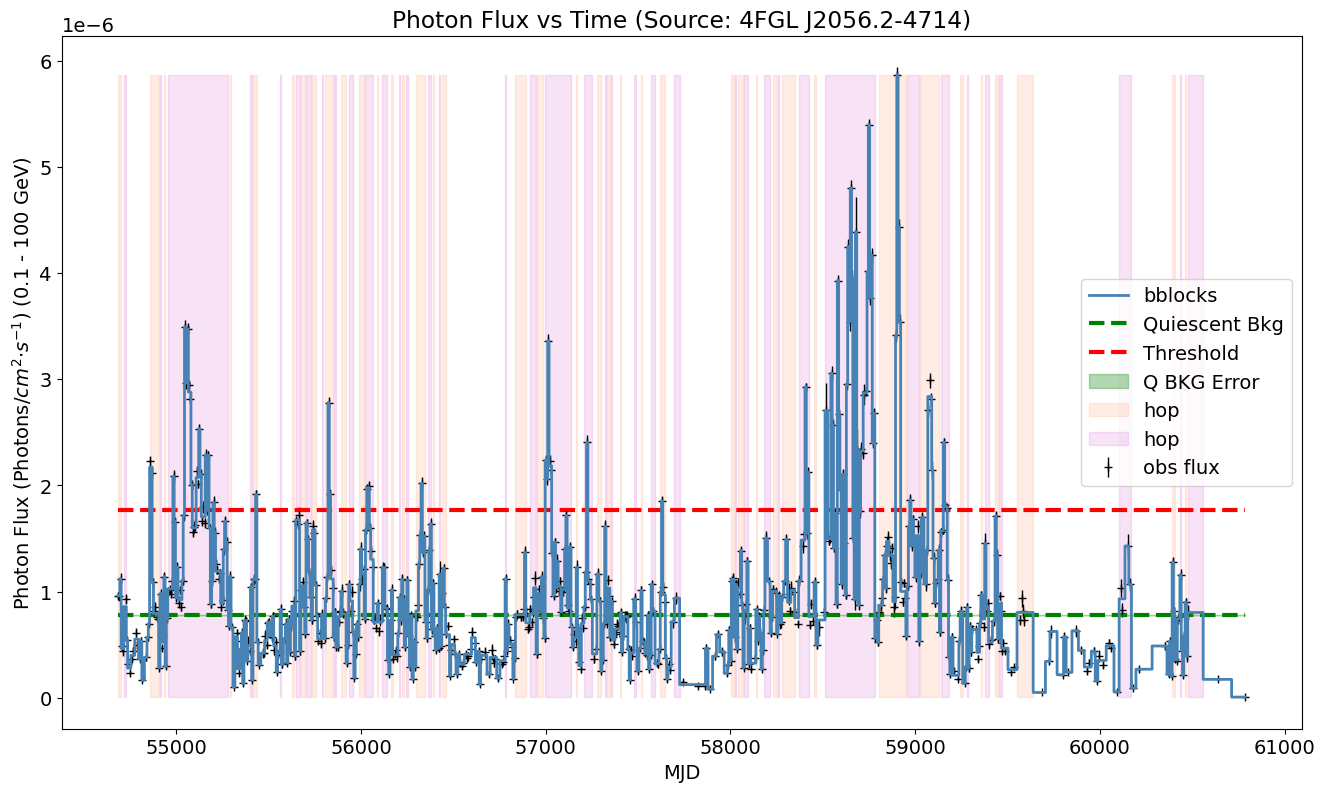

In [145]:
percent = 0.3
COSI_bkg_rate = 1
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
flarestack=[]
COSI_BAND_ALL = [0,0,0,0,0,0,0,0,0,0]
factor = 6.137620372110148
Aeff = 79.7222330985686
#sourcename = '4FGL J2253.9+1609'
sourcename = '4FGL J2056.2-4714'
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
sourcearray = sourcearray[sourcearray['photon_flux2']!=np.max(sourcearray['photon_flux2'])].reset_index(drop=True)
#sourcearray = sourcearray[0:200]
average_flux = np.mean(sourcearray['photon_flux2'])
#sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
print('Threshold Flux is '+str(thresholdflux))

# Finding first set of flares using threshold flux.
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

#if sourcelightcurve.hops == None:
#    print("No flares detected for "+str(titlestring))
#    return None


# Finding quiescent background.
quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

    

# Using quiescent background to find flares again.
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


#sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
sourcelightcurve.get_bblocks(gamma_value=0.05)
#sourcelightcurve.get_bblocks_above(threshold = 0)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)



# Plotting the Lightcurve itself.
plt.figure(figsize=(16,9))
plt.xlabel("MJD")
plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
sourcelightcurve.plot_bblocks(size=2)
sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Quiescent Bkg',lw=3,linestyle = 'dashed')
sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Threshold',lw=3,linestyle = 'dashed')


y1 = quiescent_background + qui_err
y2 = quiescent_background - qui_err
plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

sourcelightcurve.plot_hop()
#plotting_anomalies()
plt.legend()


hops_bl = sourcelightcurve.hops

flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')

flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
flareflux = flarestack[:,1].astype(float)*factor
flarenames = flarestack[:,0]
flareduration = flarestack[:,3]
background_counts = flarestack[:,4]
starttime_s = flarestack[:,5]
starttime_mjd = flarestack[:,6]
fraction_time = flarestack[:,7]
blazartype = flarestack[:,8]
asymmetry = flarestack[:,9]

COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype,asymmetry]).T
COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class','Asymmetry']

COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]

COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!=0].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration (s)']<=2e8].reset_index(drop=True)



pd.reset_option('display.max_rows')
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)','Asymmetry']
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder].sort_values('MDP99',ascending=True)

Threshold Flux is 5.934403761589582e-07
Quiescent Background: 3.951688824758495e-07, Error: 2.2211829526435953e-09


,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),Fraction of Observation Time,MDP99,Start Time (MJD),Start Time (s),Asymmetry
34,None,None,0.001306,113709.136142,62952.404562,87091200.0,87091200.0,144.0,0.165138,212.064394,58172.500012,5026104001.0,0.451389
4,None,None,0.000490,15253.250731,23612.101170,31147200.0,31147200.0,51.5,0.059060,338.123582,54945.500012,4747291201.0,-0.436893
22,None,None,0.000309,9160.480412,14903.958259,29635200.0,29635200.0,49.0,0.056193,522.453355,56835.500012,4910587201.0,0.040816
13,None,None,0.000256,6969.767304,12347.675860,27216000.0,27216000.0,45.0,0.051606,604.312338,55603.500012,4804142401.0,0.4
15,None,None,0.000156,2362.374262,7533.350063,15120000.0,15120000.0,25.0,0.028670,738.298435,55967.500012,4835592001.0,-0.2
17,None,None,0.000151,2371.036377,7270.165950,15724800.0,15724800.0,26.0,0.029817,780.161744,56296.500012,4864017601.0,-0.653846
36,None,None,0.000109,1971.804468,5239.888513,18144000.0,18144000.0,30.0,0.034404,1162.634514,59292.500012,5122872001.0,0.366667
24,None,None,0.000088,1066.975711,4253.084315,12096000.0,12096000.0,20.0,0.022936,1169.578219,57311.500012,4951713601.0,-0.85
2,None,None,0.000056,305.295123,2704.312110,5443200.0,5443200.0,9.0,0.010321,1233.997352,54840.500012,4738219201.0,-0.333333
23,None,None,0.000067,611.007177,3247.390437,9072000.0,9072000.0,15.0,0.017202,1326.571817,57192.500012,4941432001.0,-0.4


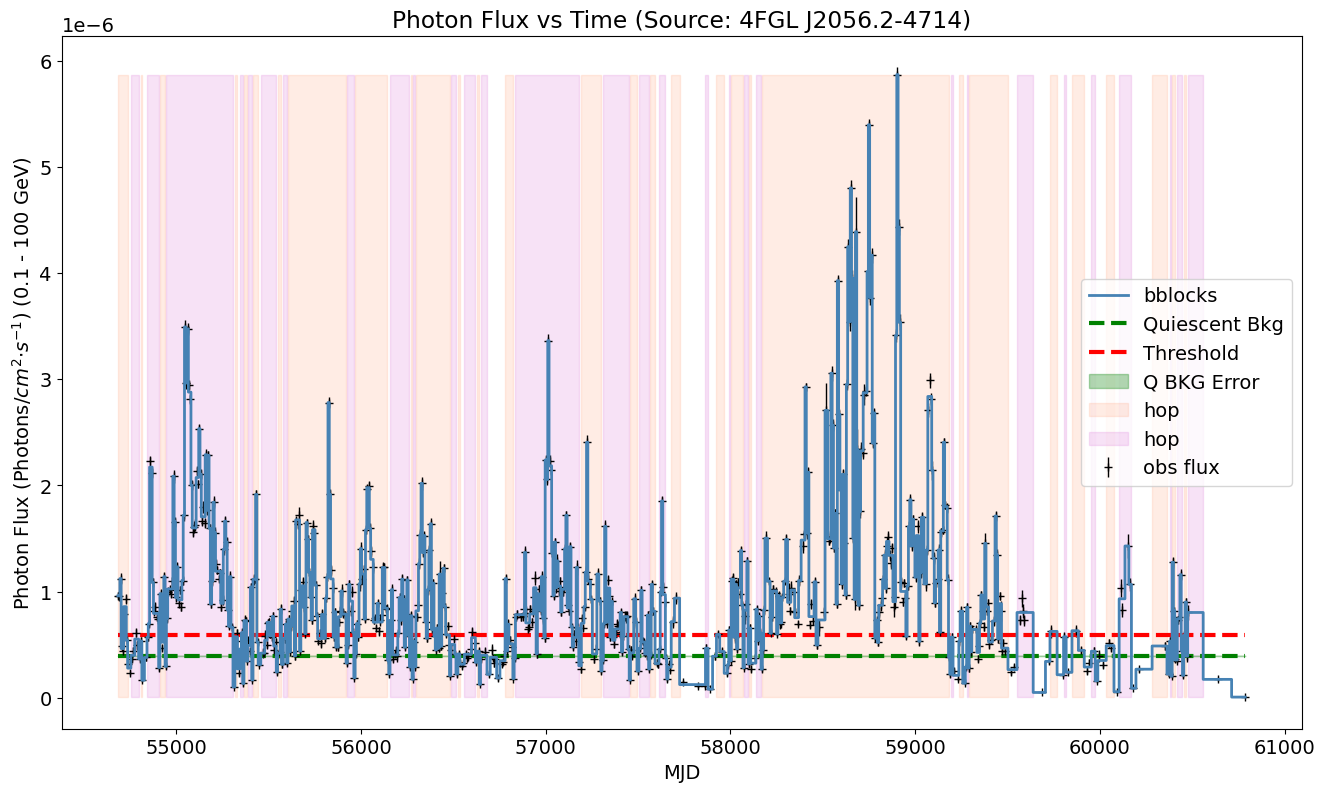

In [152]:
### HOly crap time to test to see if we should use sharp...

percent = 0.1
COSI_bkg_rate = 1
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
flarestack=[]
COSI_BAND_ALL = [0,0,0,0,0,0,0,0,0,0]
factor = 6.137620372110148
Aeff = 79.7222330985686
#sourcename = '4FGL J2253.9+1609'
sourcename = '4FGL J2056.2-4714'
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
sourcearray = sourcearray[sourcearray['photon_flux2']!=np.max(sourcearray['photon_flux2'])].reset_index(drop=True)
#sourcearray = sourcearray[0:200]
average_flux = np.mean(sourcearray['photon_flux2'])
#sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent
print('Threshold Flux is '+str(thresholdflux))

# Finding first set of flares using threshold flux.
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

#if sourcelightcurve.hops == None:
#    print("No flares detected for "+str(titlestring))
#    return None


# Finding quiescent background.
quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

    

# Using quiescent background to find flares again.
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


#sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
sourcelightcurve.get_bblocks(gamma_value=0.05)
#sourcelightcurve.get_bblocks_above(threshold = 0)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)



# Plotting the Lightcurve itself.
plt.figure(figsize=(16,9))
plt.xlabel("MJD")
plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
sourcelightcurve.plot_bblocks(size=2)
sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Quiescent Bkg',lw=3,linestyle = 'dashed')
sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Threshold',lw=3,linestyle = 'dashed')


y1 = quiescent_background + qui_err
y2 = quiescent_background - qui_err
plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

sourcelightcurve.plot_hop()
#plotting_anomalies()
plt.legend()


hops_bl = sourcelightcurve.hops

flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')

flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
flareflux = flarestack[:,1].astype(float)*factor
flarenames = flarestack[:,0]
flareduration = flarestack[:,3]
background_counts = flarestack[:,4]
starttime_s = flarestack[:,5]
starttime_mjd = flarestack[:,6]
fraction_time = flarestack[:,7]
blazartype = flarestack[:,8]
asymmetry = flarestack[:,9]

COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype,asymmetry]).T
COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class','Asymmetry']

COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]

COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!=0].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Duration (s)']<=2e8].reset_index(drop=True)



pd.reset_option('display.max_rows')
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)','Asymmetry']
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder].sort_values('MDP99',ascending=True)

Threshold Flux is 4.1920339999999995e-06
Quiescent Background: 1.2829851320754718e-06, Error: 5.597154621348001e-09
Threshold Flux is 1.2571582e-05
Quiescent Background: 1.839423412969283e-06, Error: 5.957854493690288e-09
Threshold Flux is 2.095113e-05
Quiescent Background: 2.0136399326599328e-06, Error: 6.056541152353155e-09


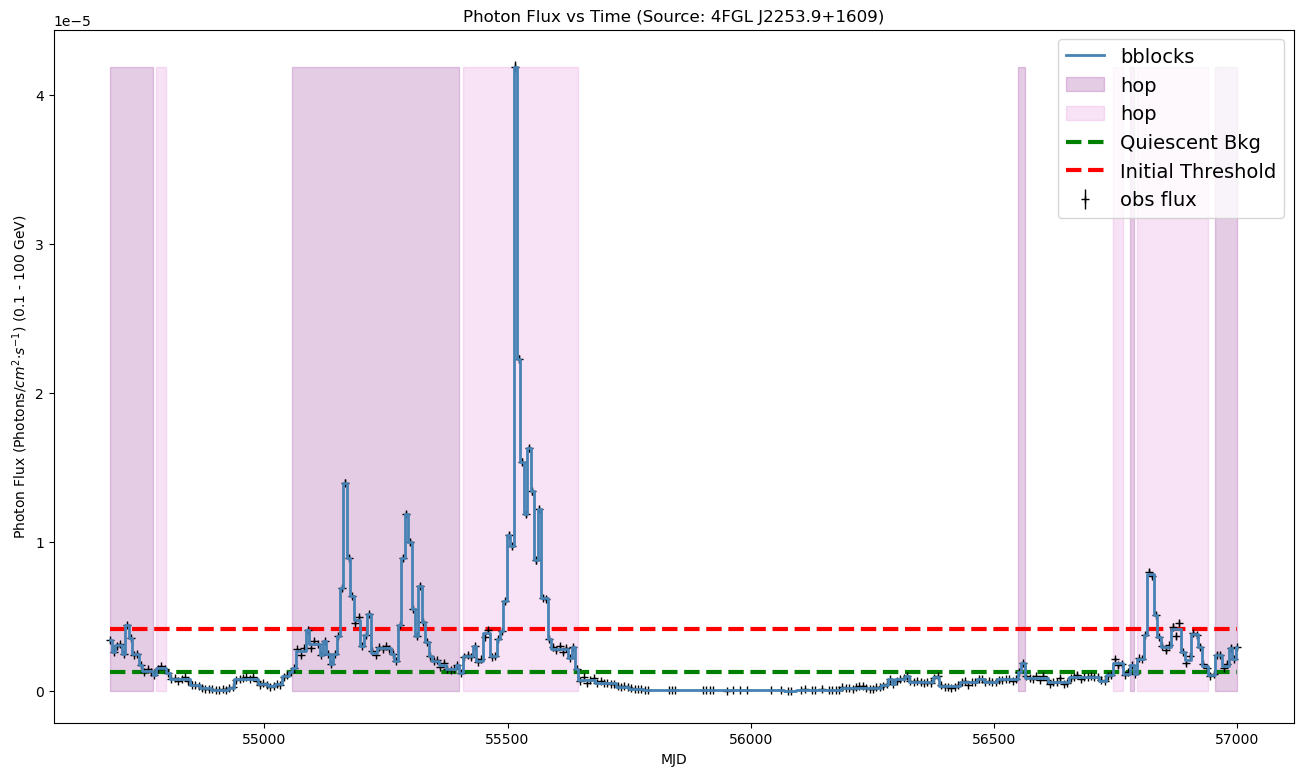

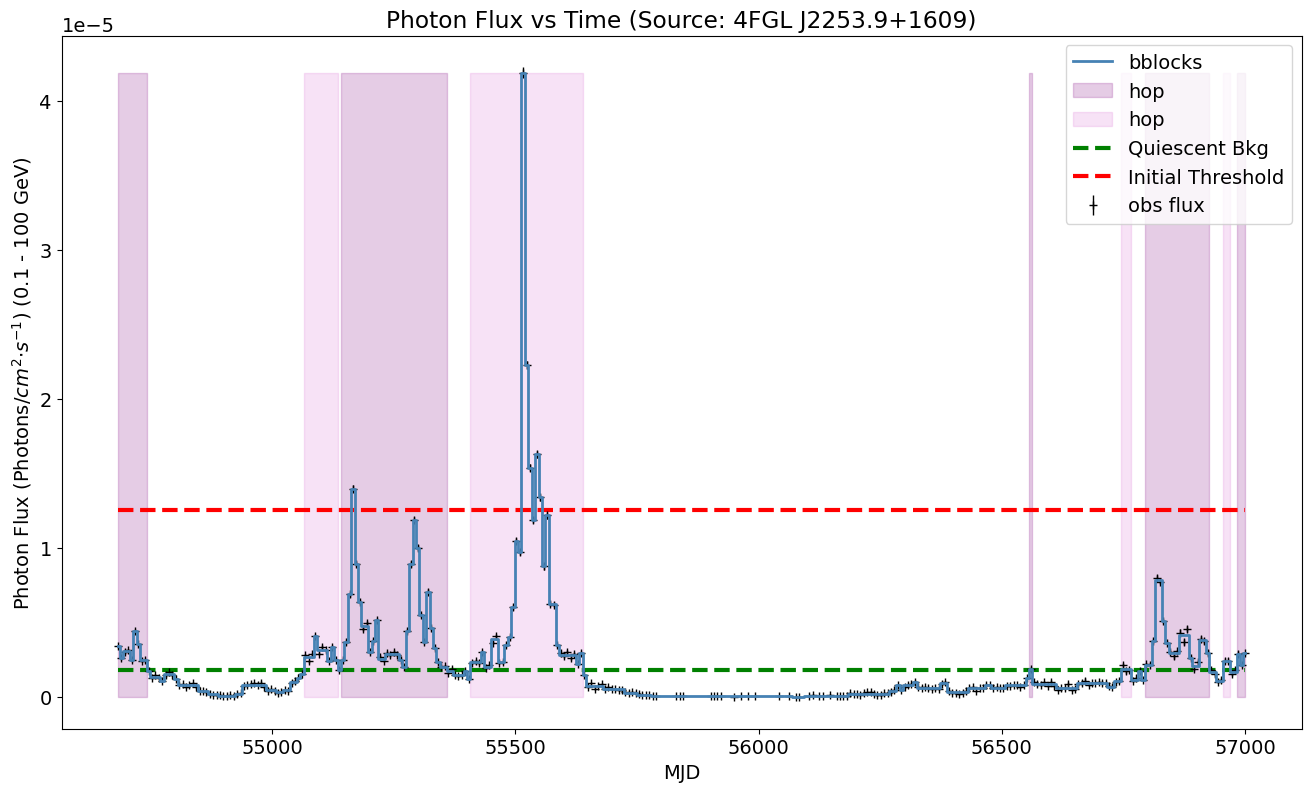

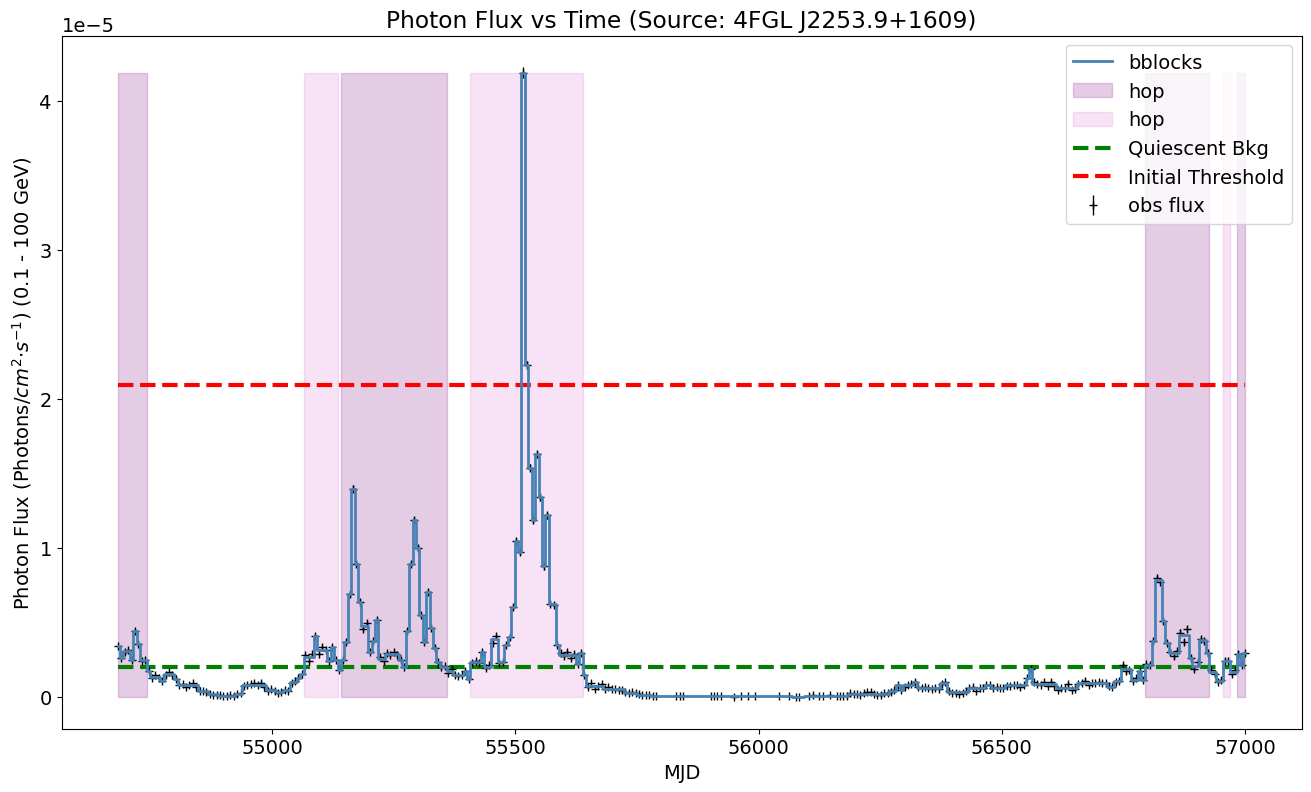

In [4]:
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0,0])
table = 'COSICSV/COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
for percent in [0.1,0.3,0.5]:
    
    #factor = 1
    percent = percent
    sourcename = '4FGL J2253.9+1609'
    factor = COSI_LAT_Sources[COSI_LAT_Sources['Name']==sourcename]['ph/s_ratio']
    Aeff = COSI_LAT_Sources[COSI_LAT_Sources['Name']==sourcename]['Aeff_mean_COSI(cm2)']
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring = sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    sourcearray = sourcearray[0:300]
    average_flux = np.mean(sourcearray['photon_flux2'])
    #sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print('Threshold Flux is '+str(thresholdflux))

    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None

    
    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    plt.rcParams.update({'font.size': 14})
    sourcelightcurve.plot_bblocks(size=2)

    y1 = quiescent_background + qui_err
    y2 = quiescent_background - qui_err
    #plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    #plotting_anomalies()
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Quiescent Bkg',lw=3,linestyle = 'dashed')
    sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Initial Threshold',lw=3,linestyle = 'dashed')
    #plotting_anomalies()
    
    plt.legend(loc='upper right')

    hops_bl = sourcelightcurve.hops


In [ ]:
len(cadence_df['source_name'].drop_duplicates(keep='first'))
fsrq_names = select_fsrq()['Source_Name']
bll_names = select_bll()['Source_Name']
bcu_names = select_bcu()['Source_Name']
print(len(fsrq_names))
print(len(bll_names))
print(len(bcu_names))